In [3]:
from utils.DL_utils import train_CNN_keras,preprocess_image

In [4]:
import pandas as pd
import os
train_dataframe = pd.read_csv(os.path.join("home/ashlee/jupter_notebook/pattern_generation/activation_map/data/random_sinusoid_period_8", "eye_rotations.csv"))

print(train_dataframe.head(5))


                                          image_name    azimuth  elevation
0  sinusoid-0_-7.150982152169262_-7.1509821521692...  -7.150982  -7.150982
1  sinusoid-1_-0.466664551802269_-7.1509821521692...  -0.466665  -7.150982
2  sinusoid-2_14.81655691553061_-7.15098215216926...  14.816557  -7.150982
3  sinusoid-3_4.282040529968586_-7.15098215216926...   4.282041  -7.150982
4  sinusoid-4_11.30282519368279_-7.15098215216926...  11.302825  -7.150982


In [5]:
def train_CNN_regression(
    train_dataframe,
    train_directory,
    x_col,
    y_col,
    target_size=(256, 256),
    batch_size=128,
    num_output=2,
    num_epochs=20,
    verbose=0,
):
    """
    Trains a conv net for a given dataset contained within a training directory.
    Users can just supply the path of the training directory and get back a fully trained, 5-layer, convolutional network.
    
    Arguments:
            train_directory: The directory where the training images are stored in separate folders.
                            These folders should be named as per the classes.
            target_size: Target size for the training images. A tuple e.g. (200,200)
            classes: A Python list with the classes 
            batch_size: Batch size for training
            num_epochs: Number of epochs for training
            num_classes: Number of output classes to consider
            verbose: Verbosity level of the training, passed on to the `fit_generator` method
    Returns:
            A trained conv net model
    
    """
    from keras.layers import Conv2D, MaxPooling2D
    from keras.layers import Dense, Dropout, Flatten
    from keras.models import Sequential
    from keras.preprocessing.image import ImageDataGenerator
    
    # ImageDataGenerator object instance with scaling
    train_datagen = ImageDataGenerator(rescale=1 / 255)
    
    # Flow training images in batches using the generator
    train_generator = train_datagen.flow_from_dataframe(
        train_dataframe,  # This is the source dataframe for training images
        train_directory,  # This is the source directory for training images
        target_size=target_size,  # All images will be resized to 200 x 200
        x_col=x_col,  # column in dataframe that contains the filenames
        y_col=y_col,  # string or list of columns in dataframe that has the target data
        batch_size=batch_size,
        class_mode="raw",
        validate_filenames=True
    )

    input_shape = tuple(list(target_size) + [3])

    # Model architecture
    model = Sequential(
        [
            # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
            # The first convolution
            Conv2D(16, (3, 3), activation="relu", input_shape=input_shape),
            MaxPooling2D(2, 2),
            # The second convolution
            Conv2D(32, (3, 3), activation="relu"),
            MaxPooling2D(2, 2),
            # The third convolution
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D(2, 2),
            # The fourth convolution
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D(2, 2),
            # The fifth convolution
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D(2, 2),
            # Flatten the results to feed into a dense layer
            Flatten(),
            # 512 neuron in the fully-connected layer
            Dense(512, activation="relu"),
            # Output neurons for `num_classes` classes with the softmax activation
            Dense(num_output),
        ]
    )

    # Optimizer and compilation
    model.compile(
        loss="mse", optimizer="Adam", metrics=["mse", "mae"]
    )
    
    model.summary()

    # Total sample count
    total_sample = train_generator.n

    # Training
    model.fit_generator(
        train_generator,
        steps_per_epoch=int(total_sample / batch_size),
        epochs=num_epochs,
        verbose=verbose,
    )

    return model

In [6]:
import pandas as pd
import os
train_directory = "home/ashlee/jupter_notebook/pattern_generation/activation_map/data/random_sinusoid_period_8/data/random_sinusoid_period_8"
train_dataframe = pd.read_csv(os.path.join(train_directory, "eye_rotations.csv"))
x_col = "image_name"
y_col = ["azimuth", "elevation"]
target_size = (256,256)
batch_size = 32
num_output = 2
num_epochs = 10

### Train the model

In [7]:
model = train_CNN_regression(train_dataframe=train_dataframe,
                             train_directory=train_directory,
                            x_col=x_col,
                            y_col=y_col,
                            num_output=num_output,
                            target_size=target_size,
                            batch_size=batch_size,
                            num_epochs=num_epochs,
                            verbose=1)

Using TensorFlow backend.


Found 1024 validated image filenames.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D

In [18]:
img_path = "home/ashlee/jupter_notebook/pattern_generation/activation_map/data/random_sinusoid_period_8/data/random_sinusoid_period_8/sinusoid-629_-10.789442811404937_11.198533744171154.png"

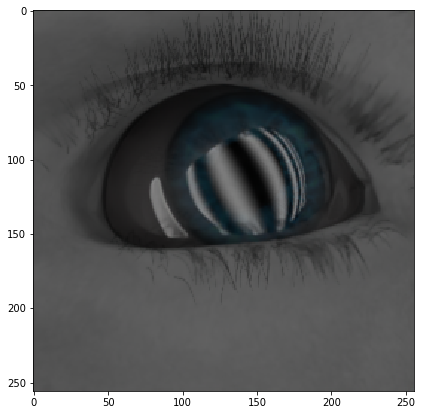

In [19]:
import matplotlib.pyplot as plt
import PIL
plt.figure(figsize=(8,7))
plt.imshow(PIL.Image.open(img_path))
plt.show()

In [20]:
x = preprocess_image(img_path=img_path,model=model,resize=target_size)

### We can check the model prediction (probabilities)

In [21]:
model.predict(x)

array([[-10.7771845,  10.562988 ]], dtype=float32)

The ground truth angles are [azimuth, elevation] = [5.452, 1.858] and the predicted angles are [5.970, 1.943]

### Generate the activation maps

It is as easy as,
```
from keract import get_activations
activations = get_activations(model, x, layer_name)
```

- `model` is a keras.models.Model object.
- `x` is a numpy array to feed to the model as input. In the case of multi-input, x is of type List. We use the Keras convention (as used in predict, fit...).
- `layer_name` (optional) - the layer to get activations for if you only want the activations for one layer

In [23]:
from keract import get_activations, display_activations
activations = get_activations(model, x)

Run it without eager mode. Paste those commands at the beginning of your script:
> import tensorflow as tf
> tf.compat.v1.disable_eager_execution()


### Display the activation maps
The code is,
```
from keract import display_activations
display_activations(activations, cmap="gray", save=False)
```
- `activations` a dictionary mapping layers to their activations (the output of get_activations)
- `cmap` (optional) a string of a valid matplotlib colourmap
- `save` (optional) a bool, if True the images of the activations are saved rather than being shown


conv2d_1_input (1, 256, 256, 3) 


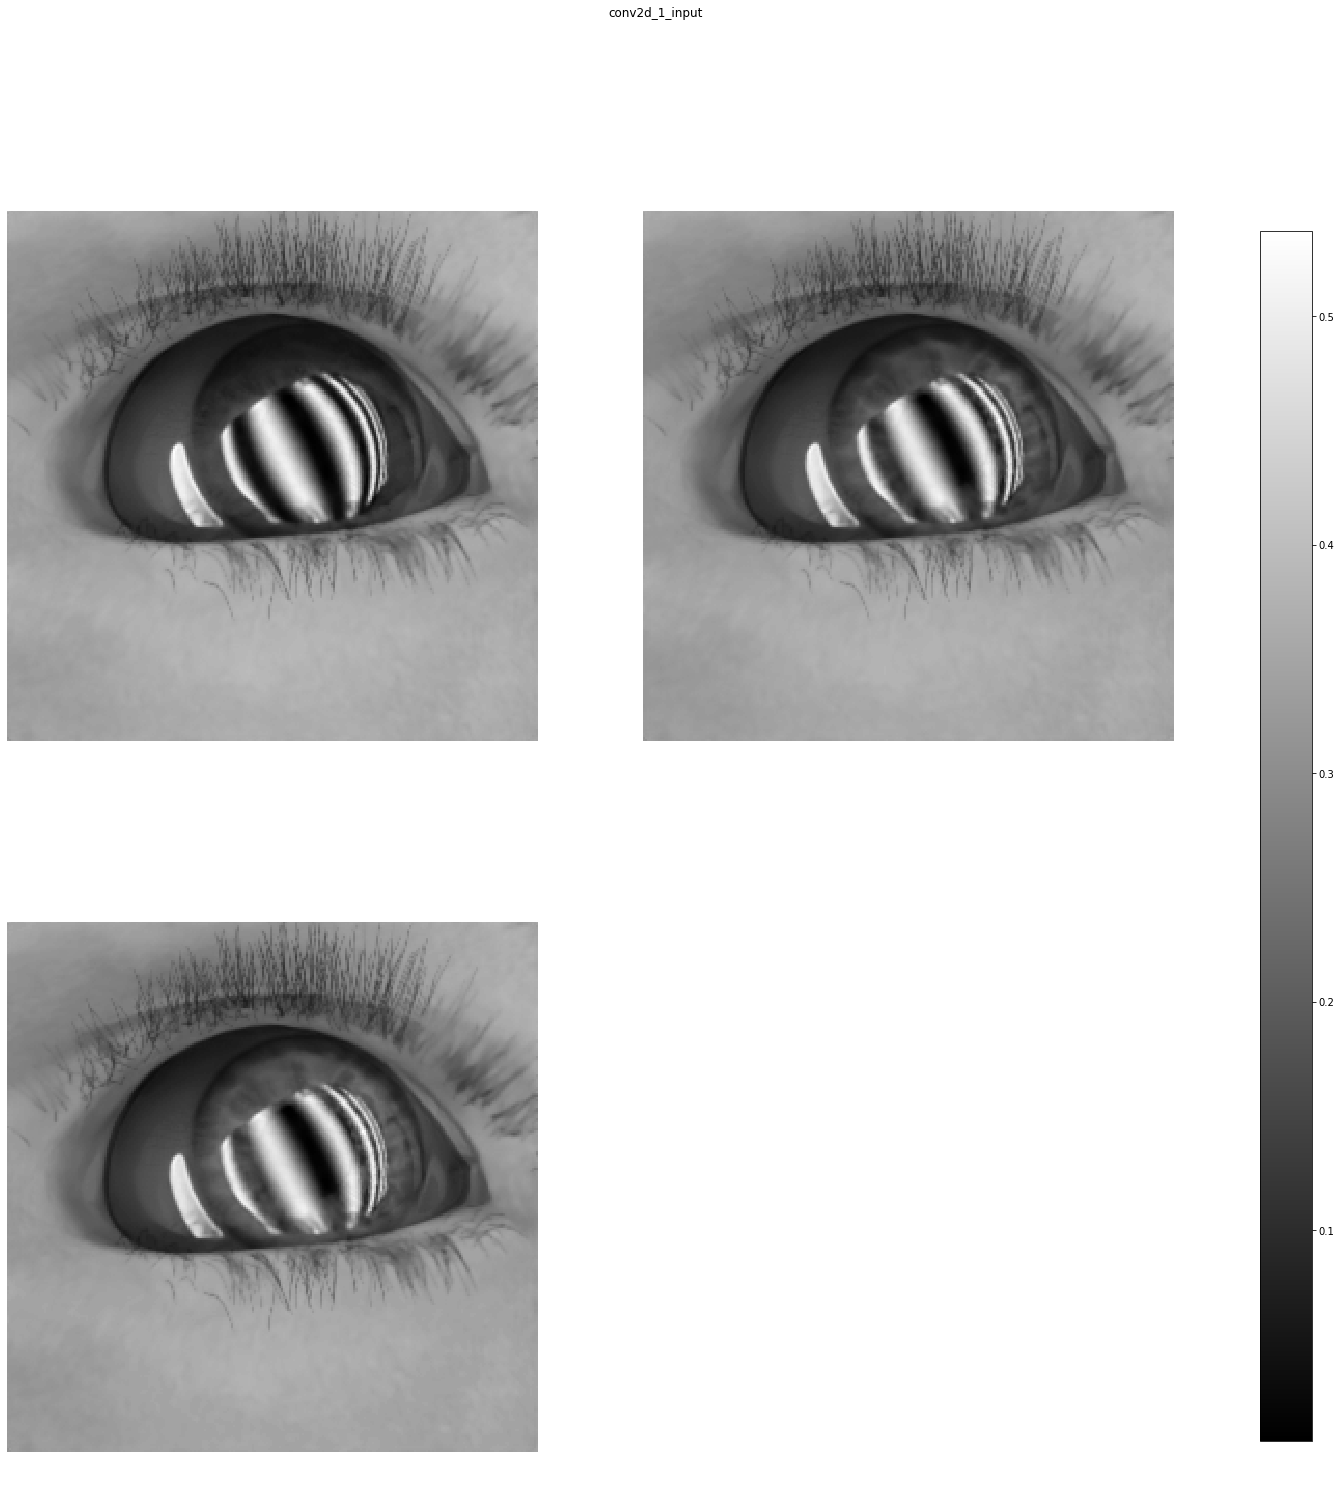

conv2d_1 (1, 254, 254, 16) 


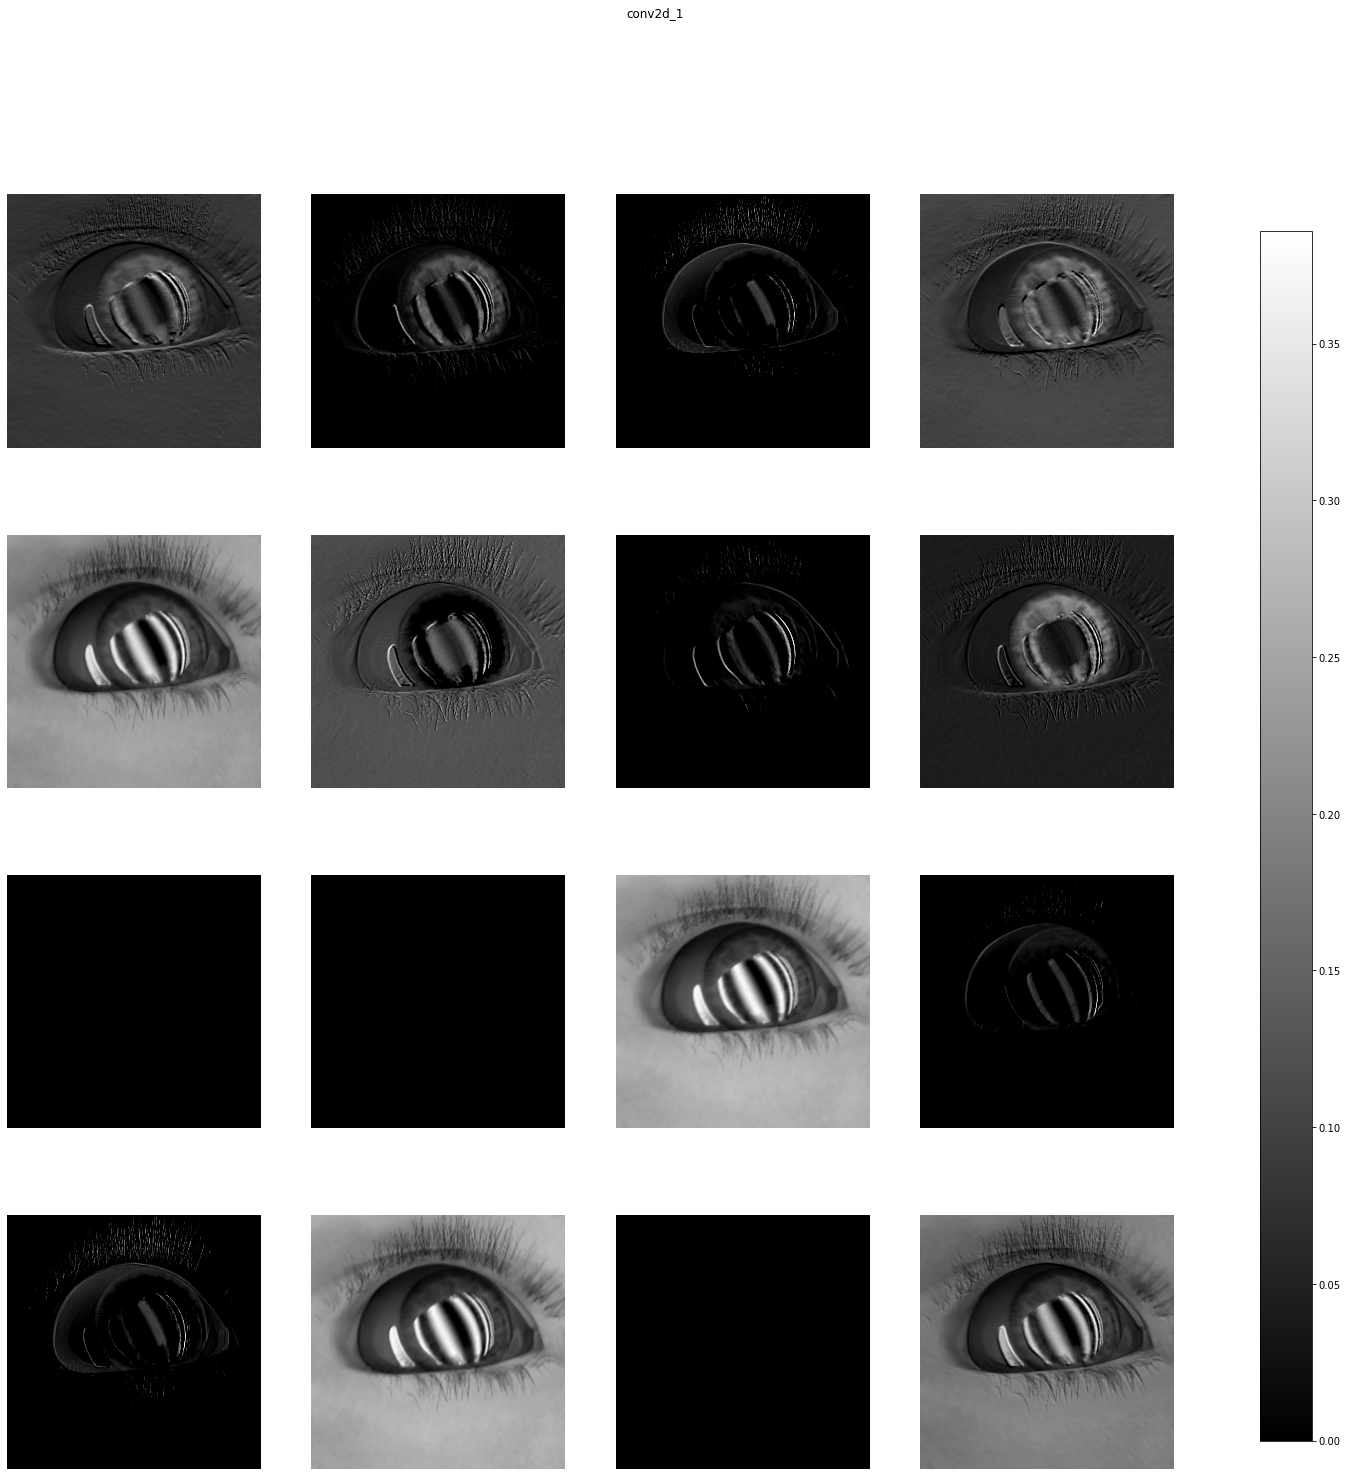

max_pooling2d_1 (1, 127, 127, 16) 


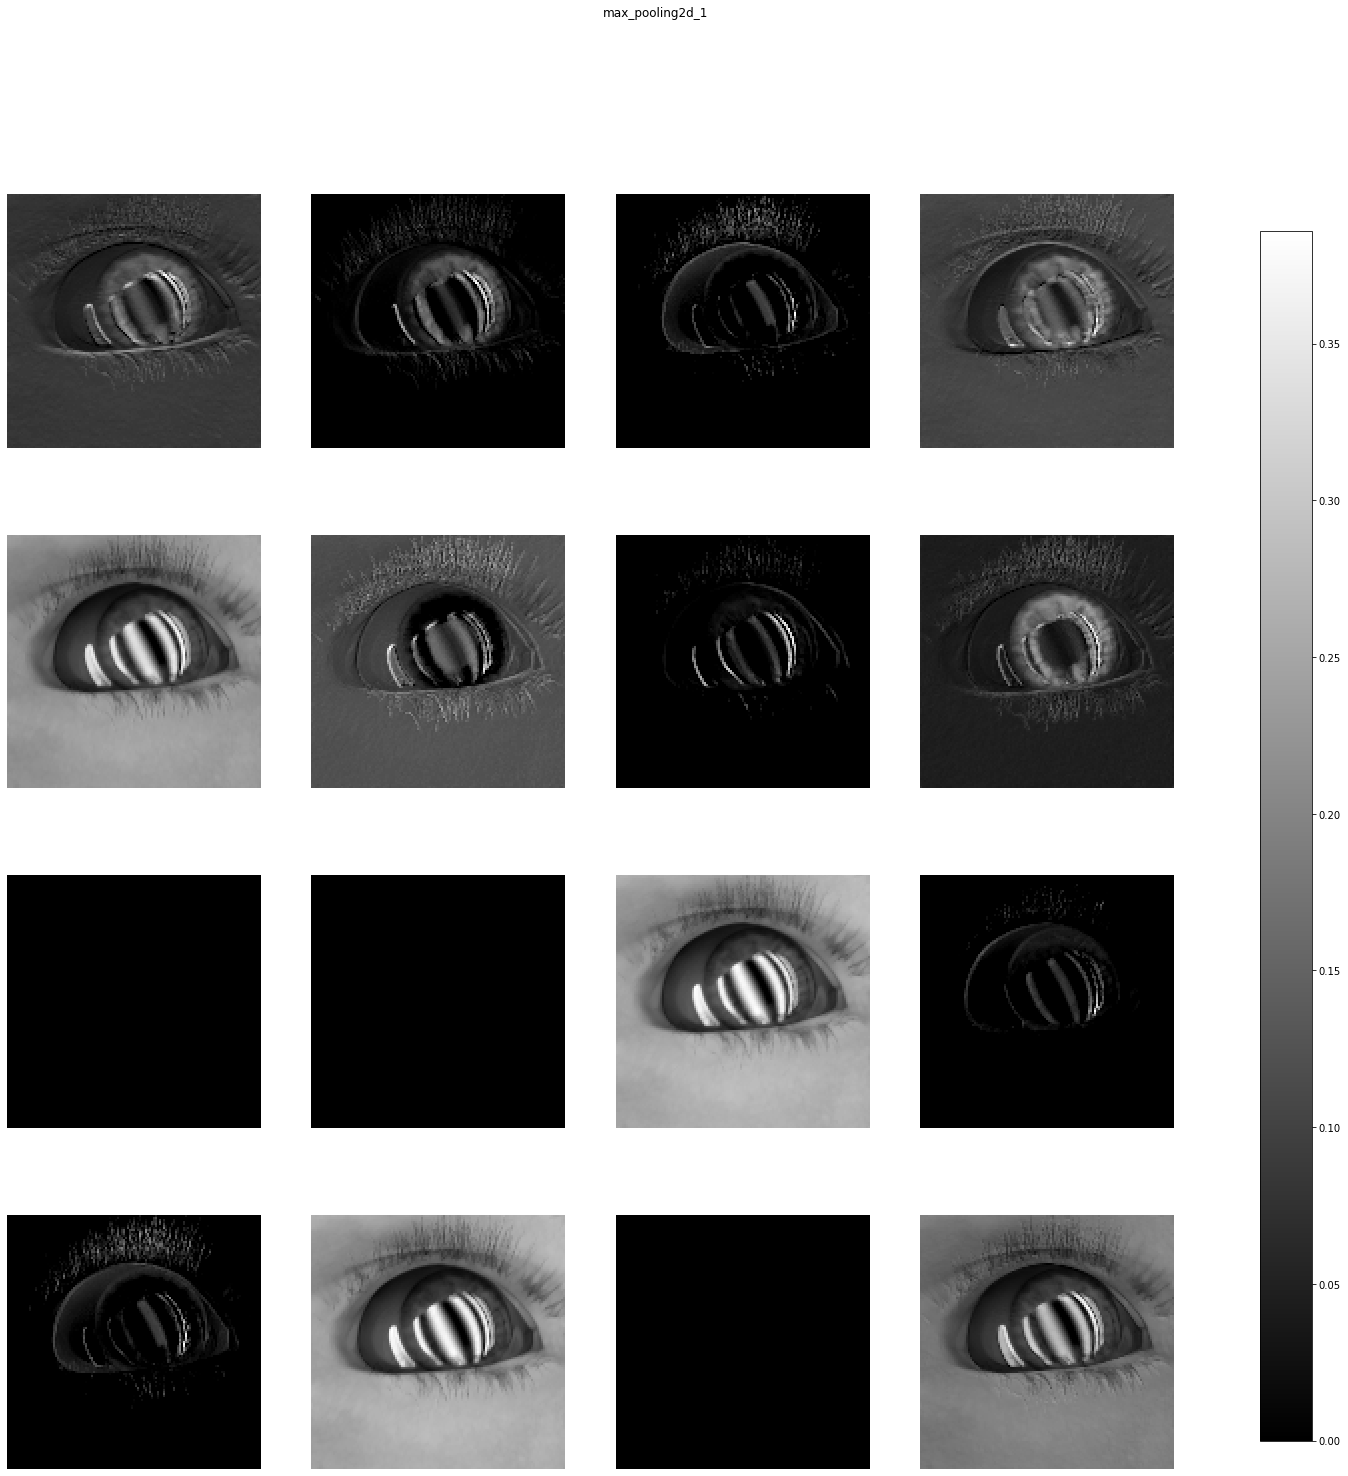

conv2d_2 (1, 125, 125, 32) 


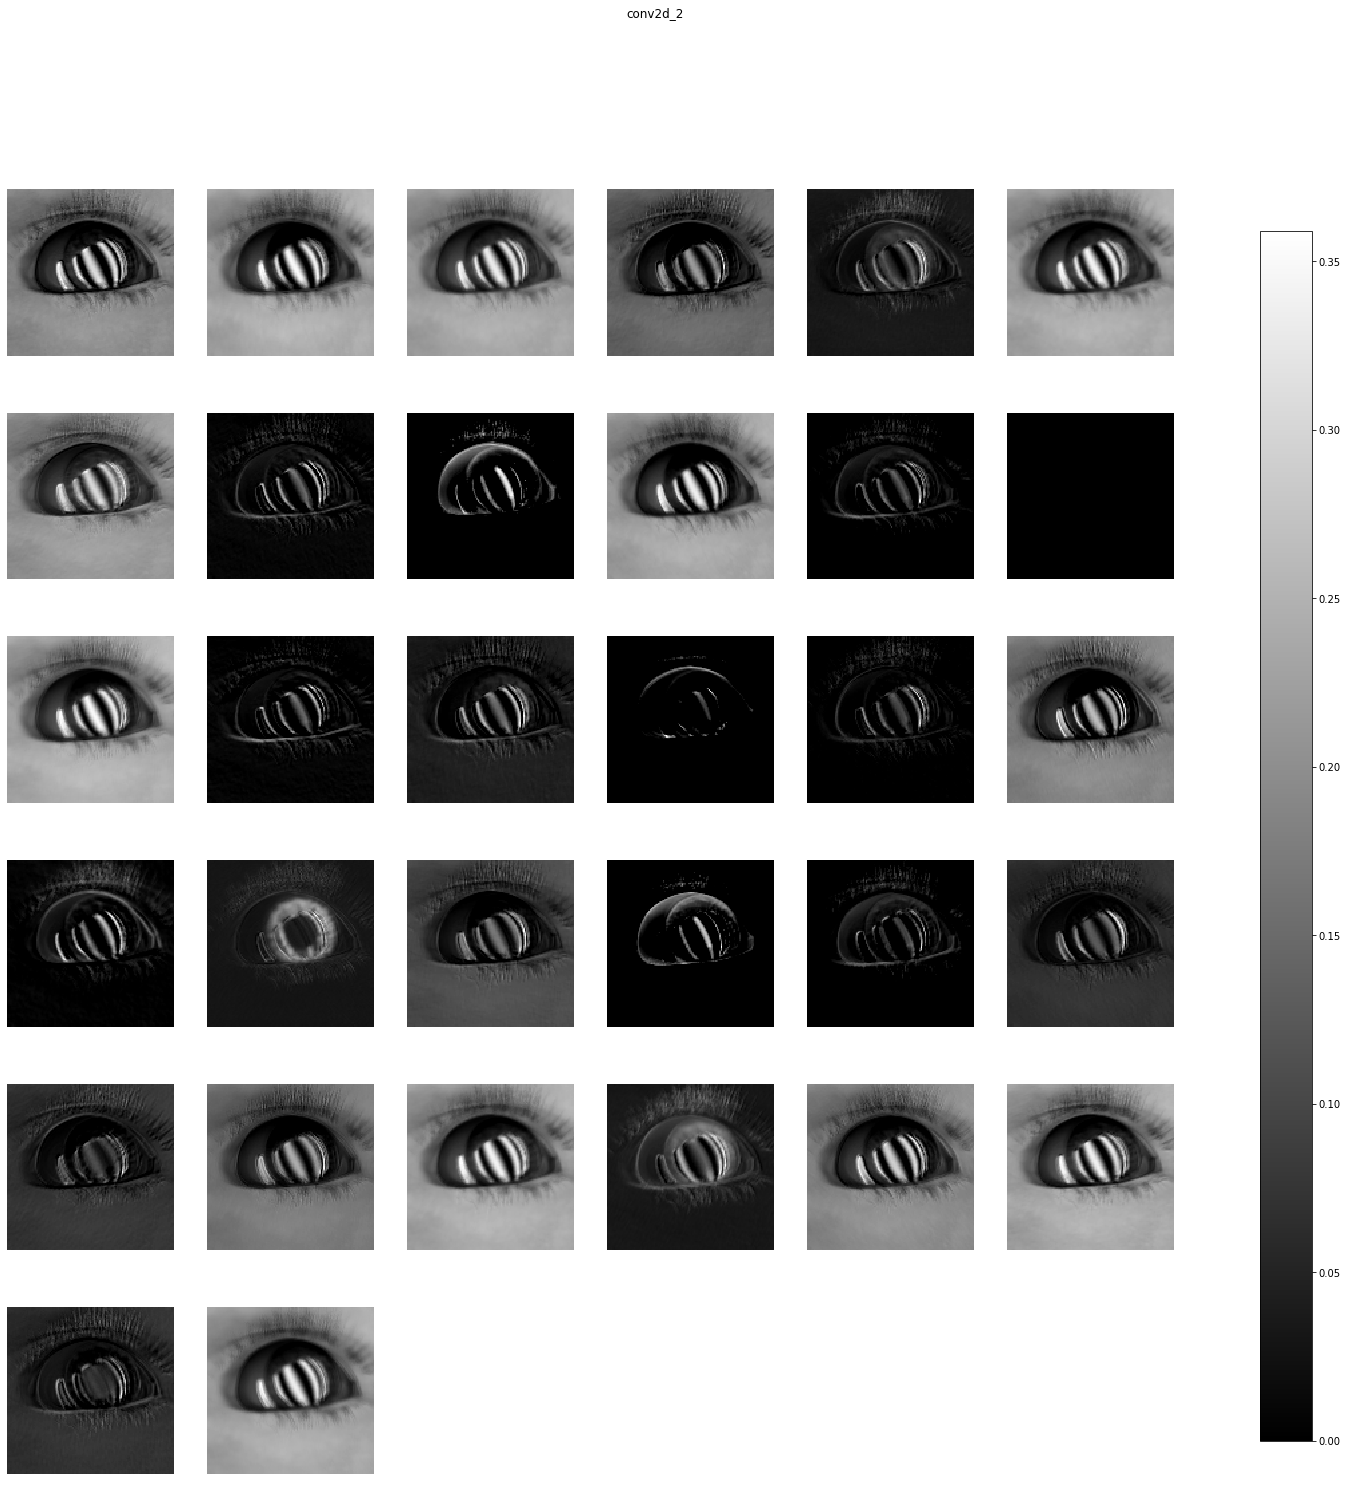

max_pooling2d_2 (1, 62, 62, 32) 


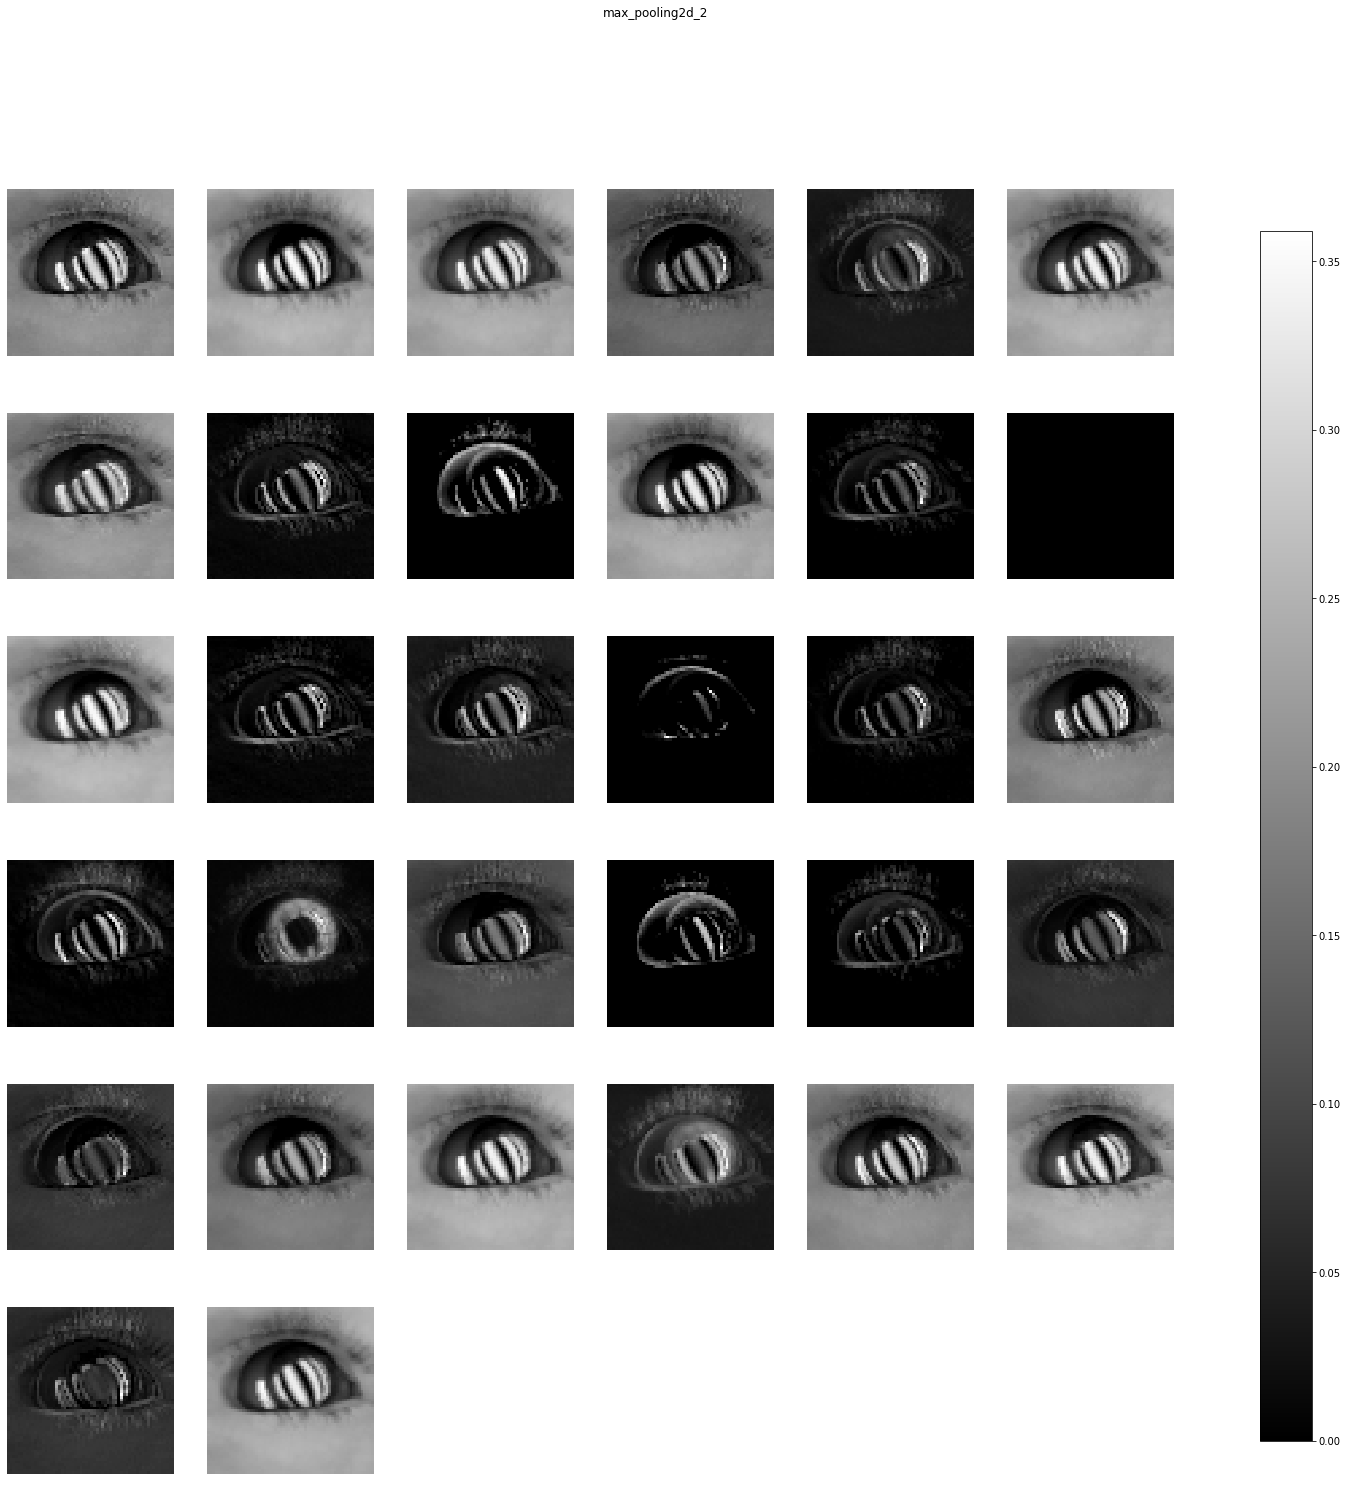

conv2d_3 (1, 60, 60, 64) 


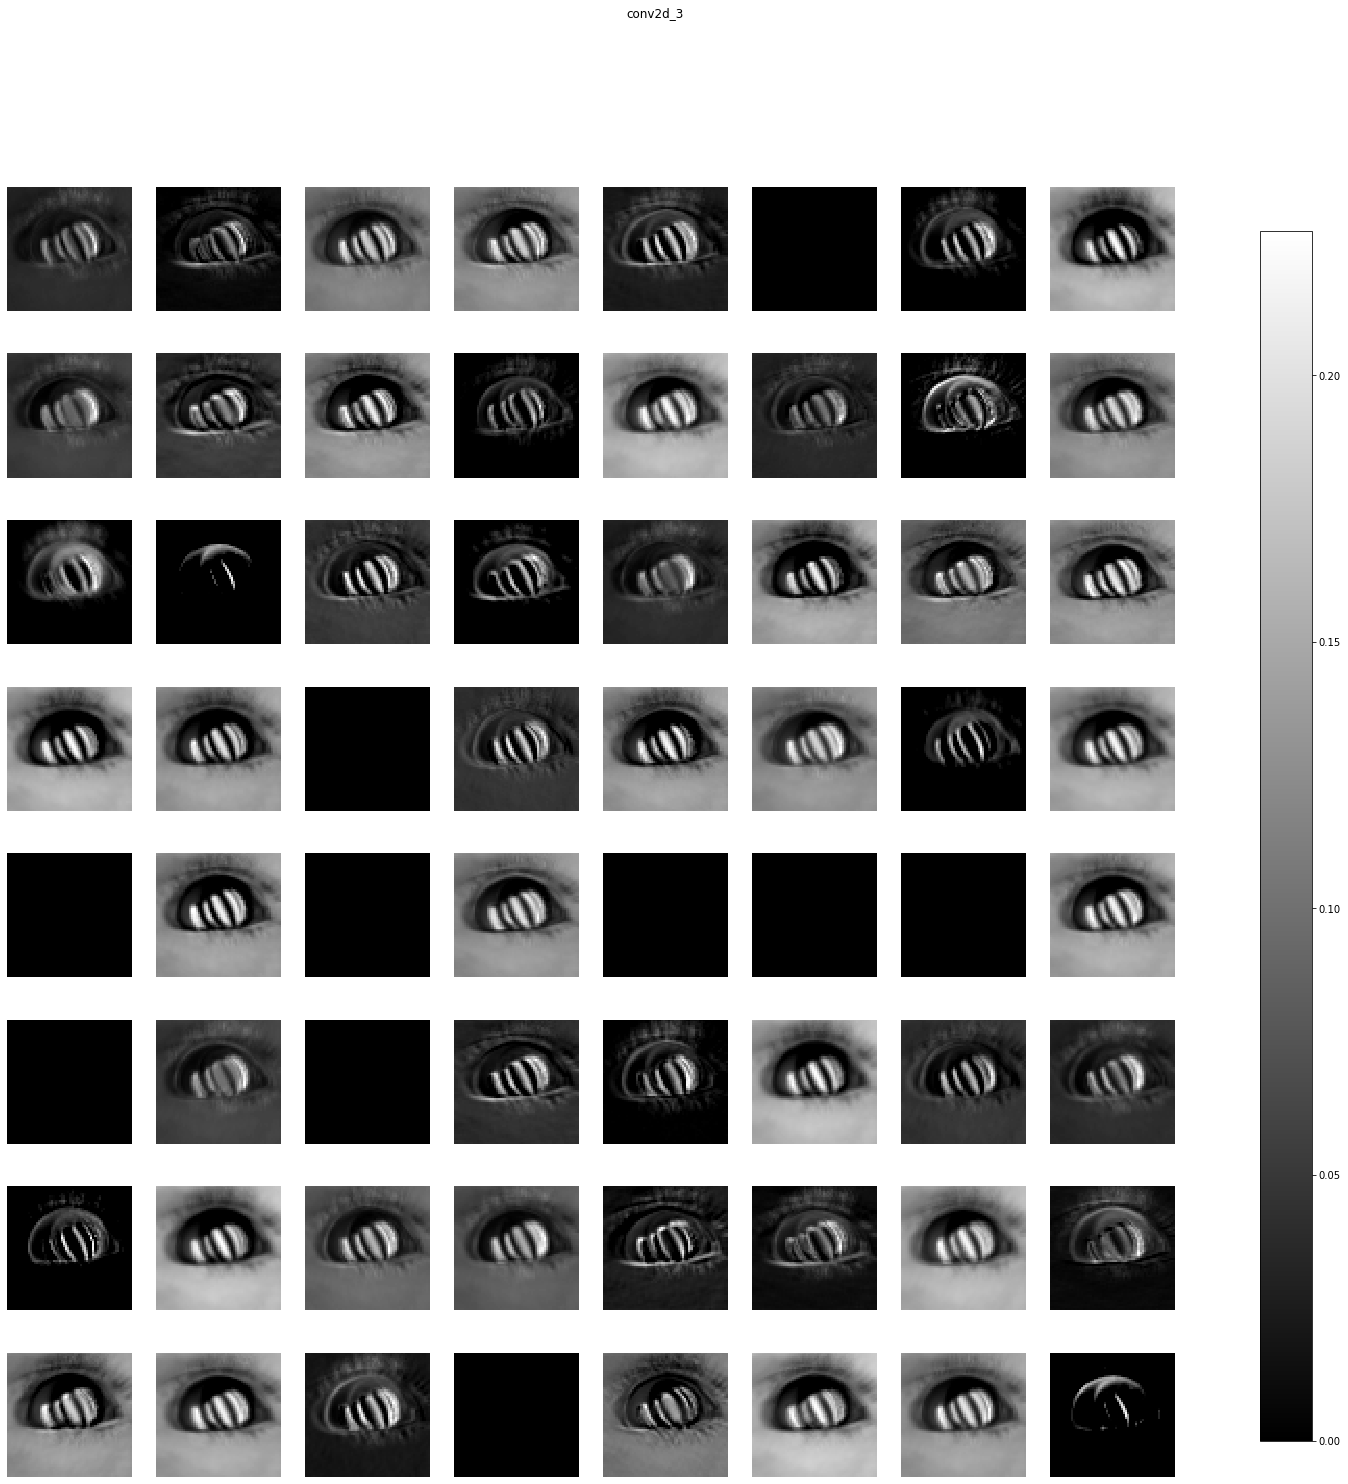

max_pooling2d_3 (1, 30, 30, 64) 


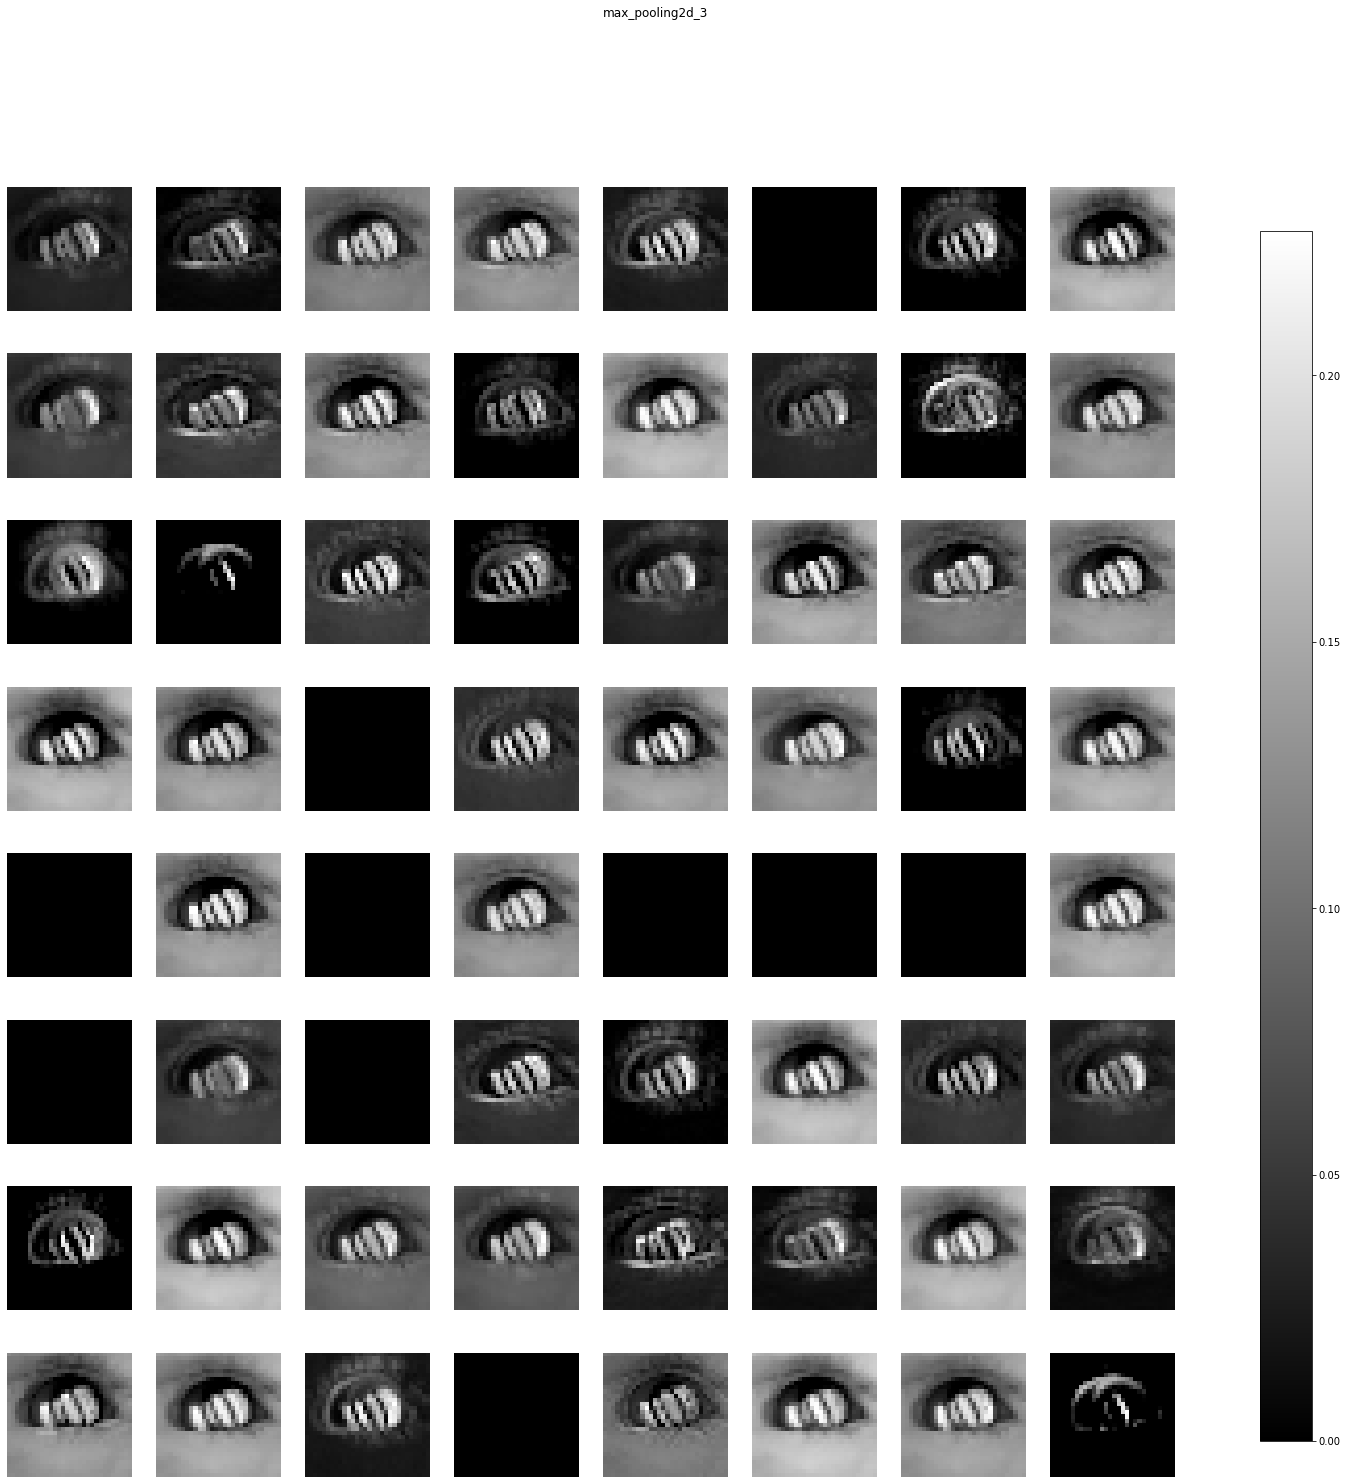

conv2d_4 (1, 28, 28, 64) 


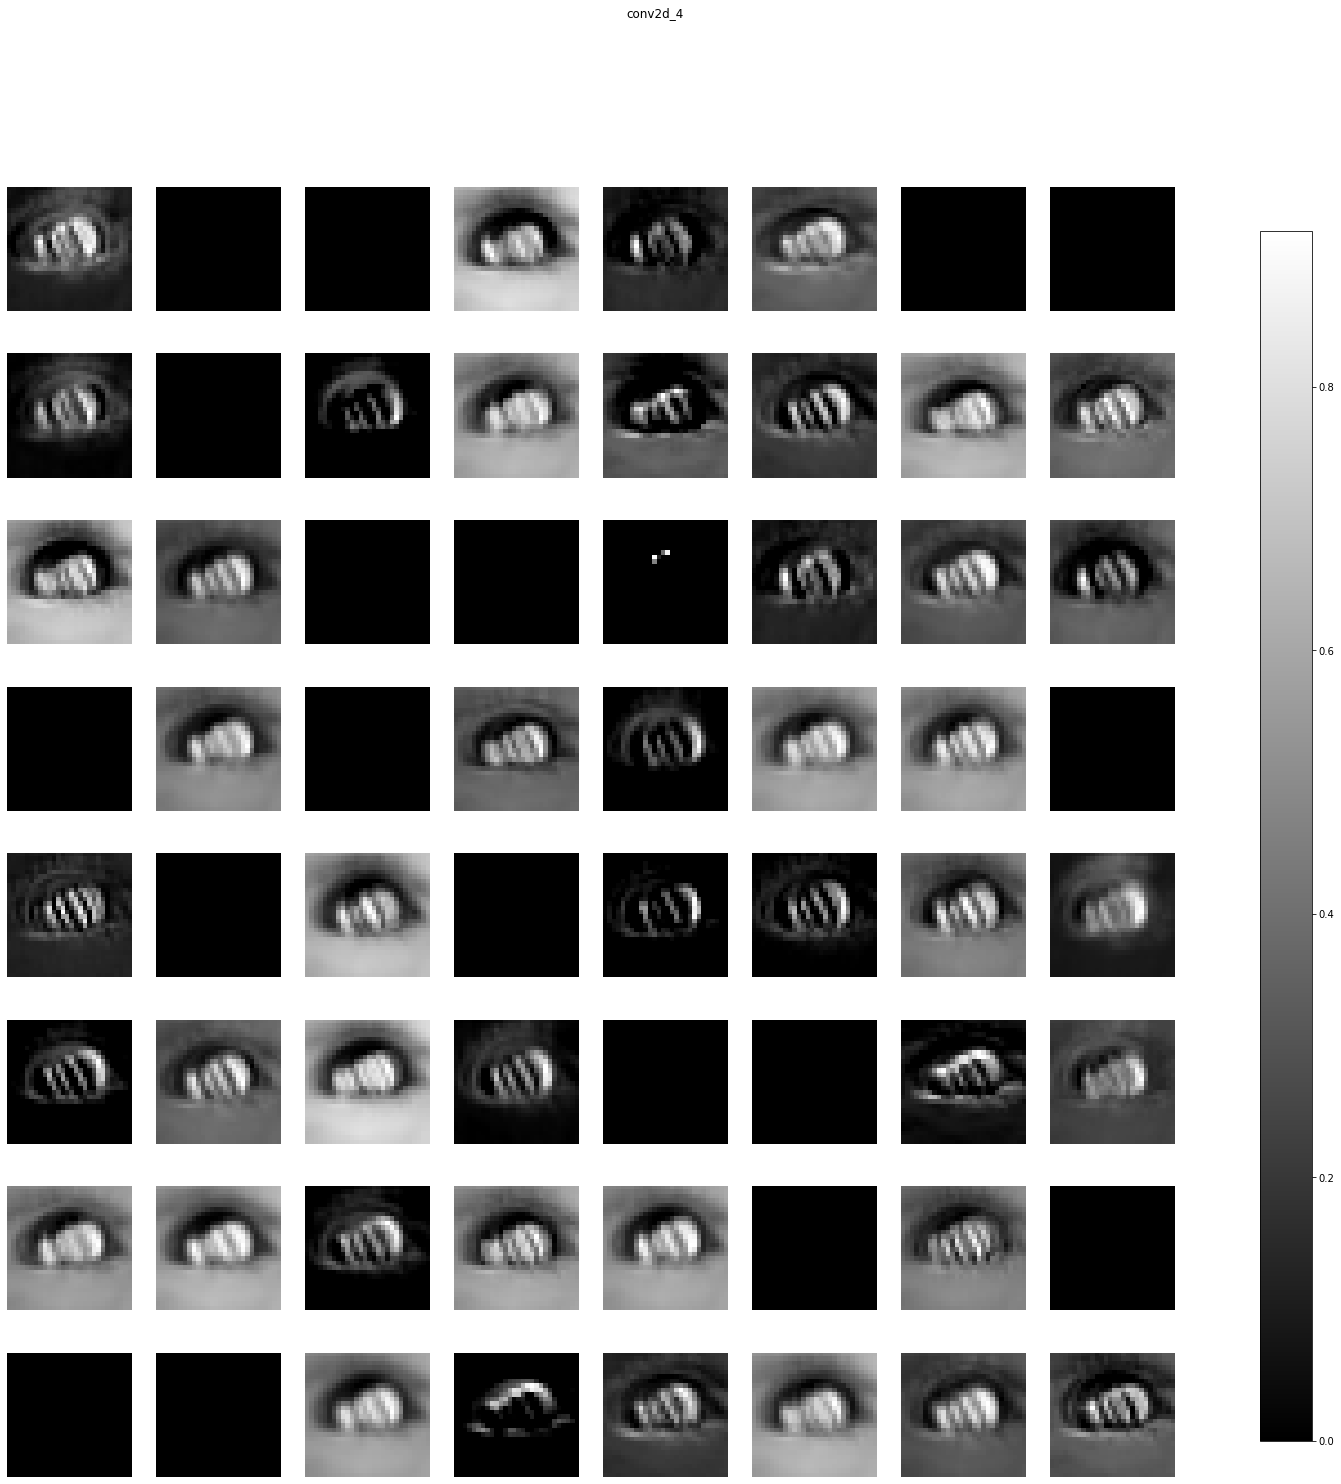

max_pooling2d_4 (1, 14, 14, 64) 


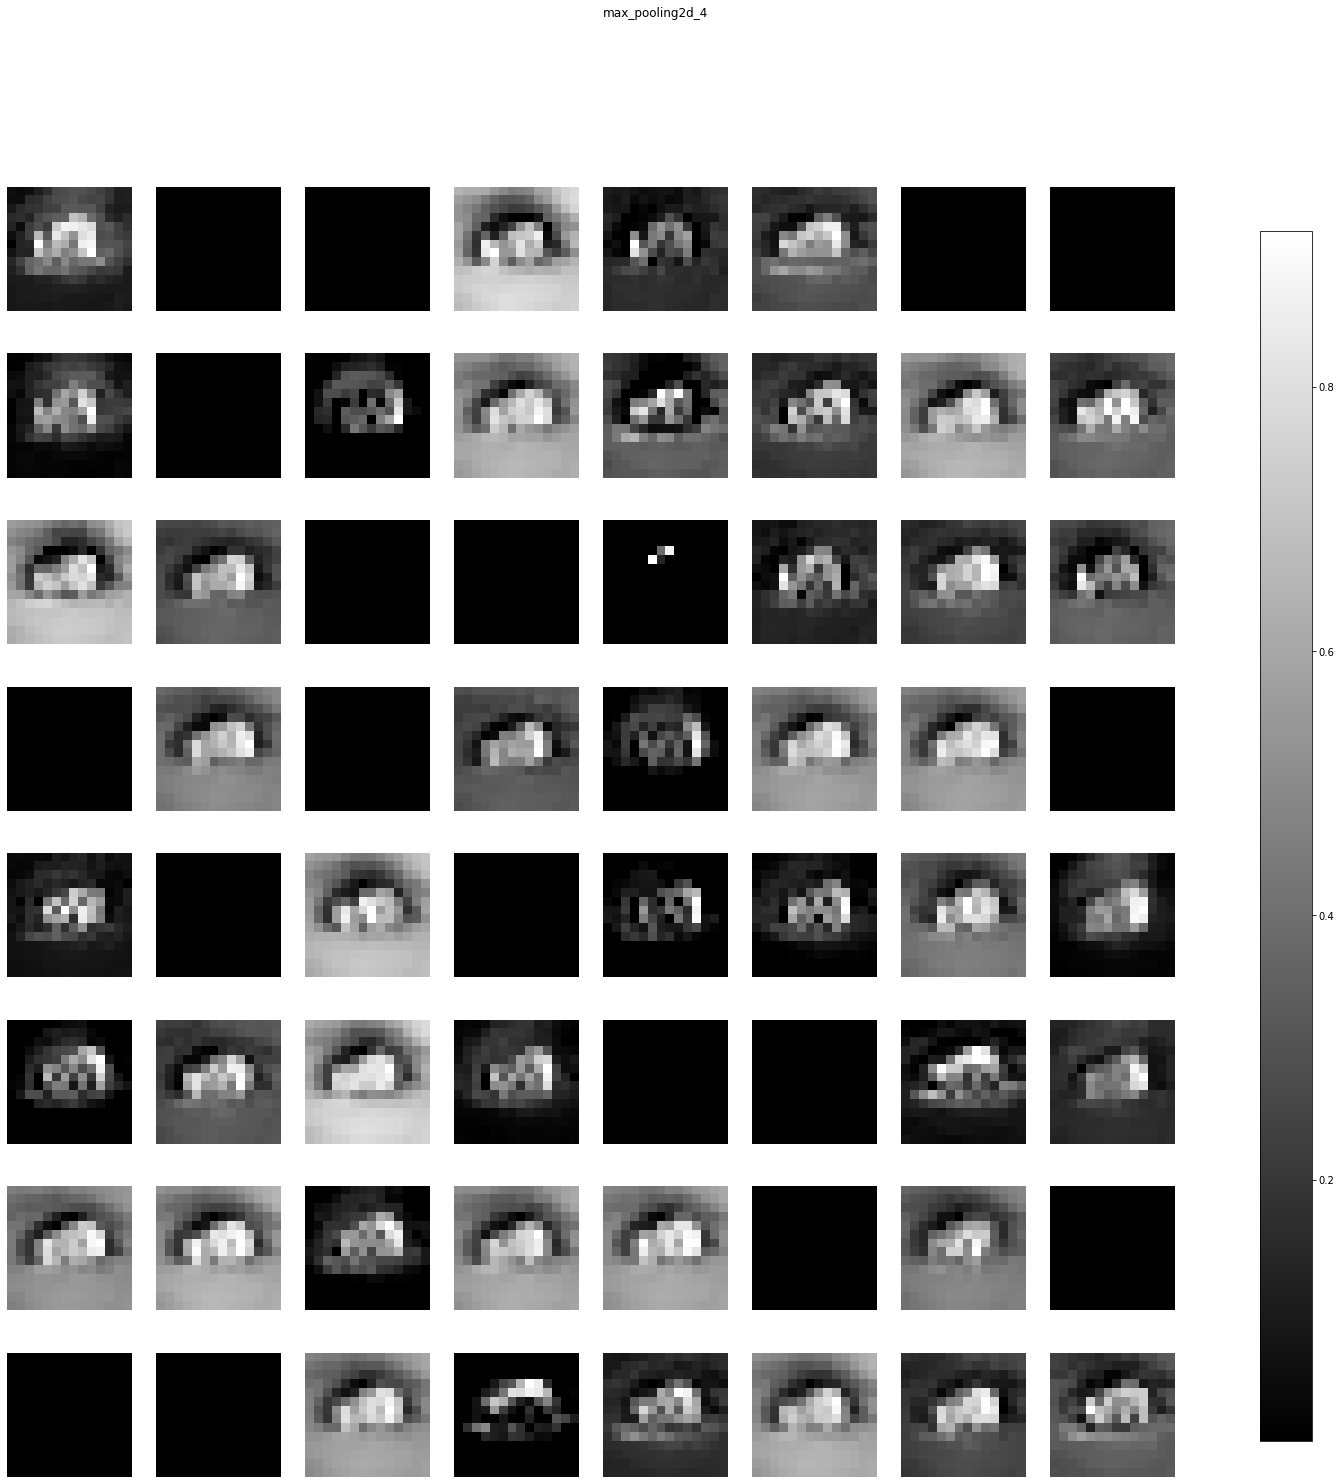

conv2d_5 (1, 12, 12, 64) 


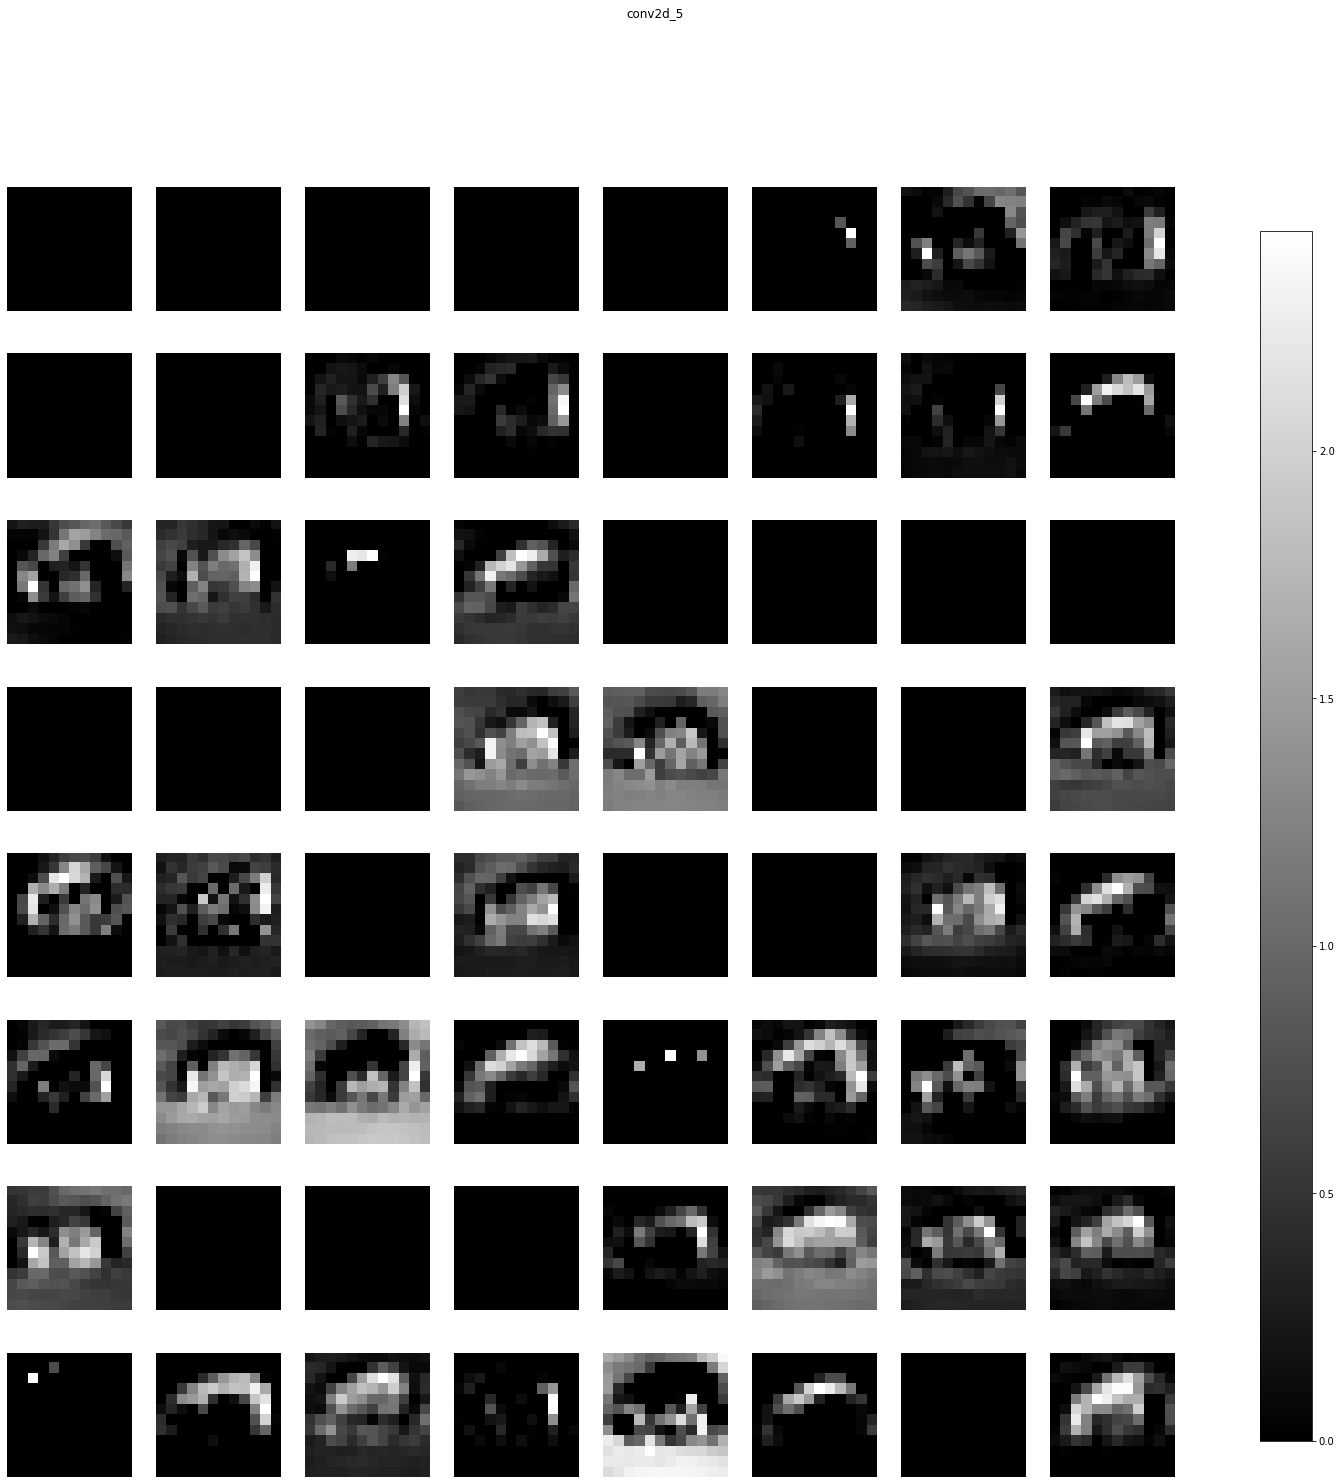

max_pooling2d_5 (1, 6, 6, 64) 


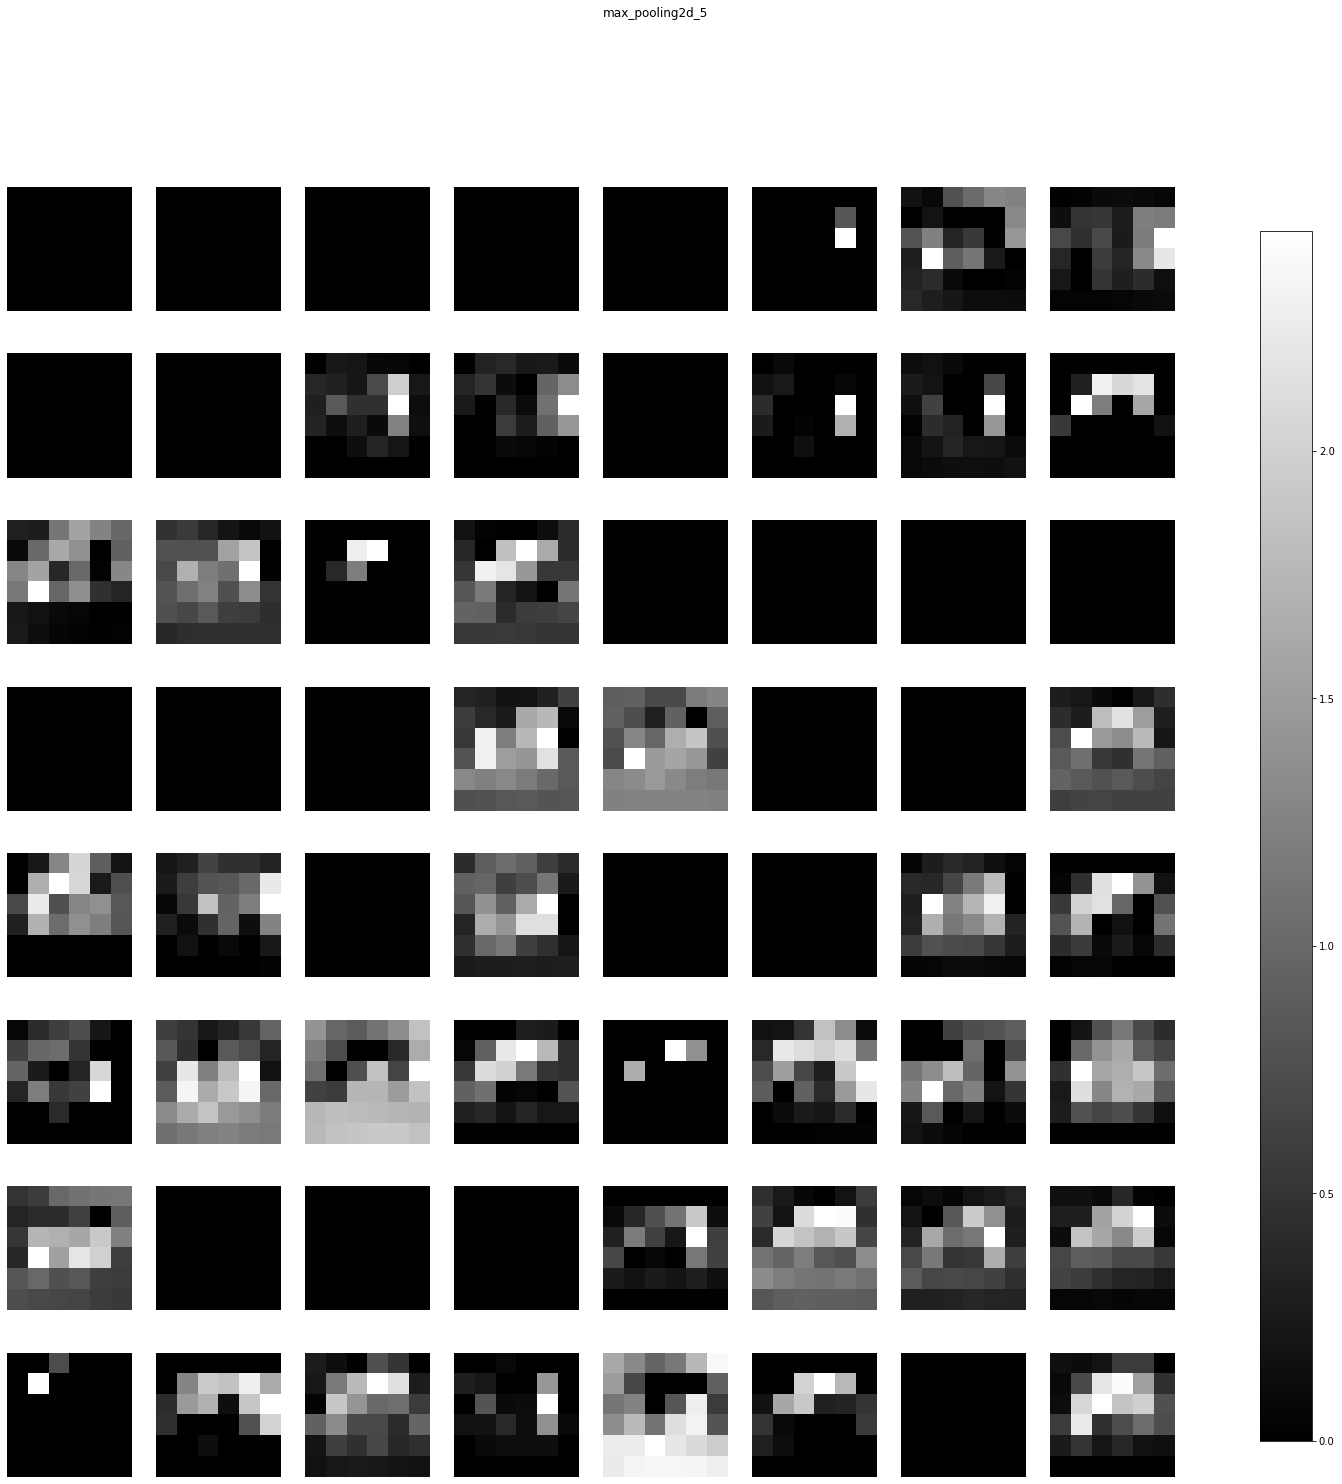

flatten_1 (1, 2304) 


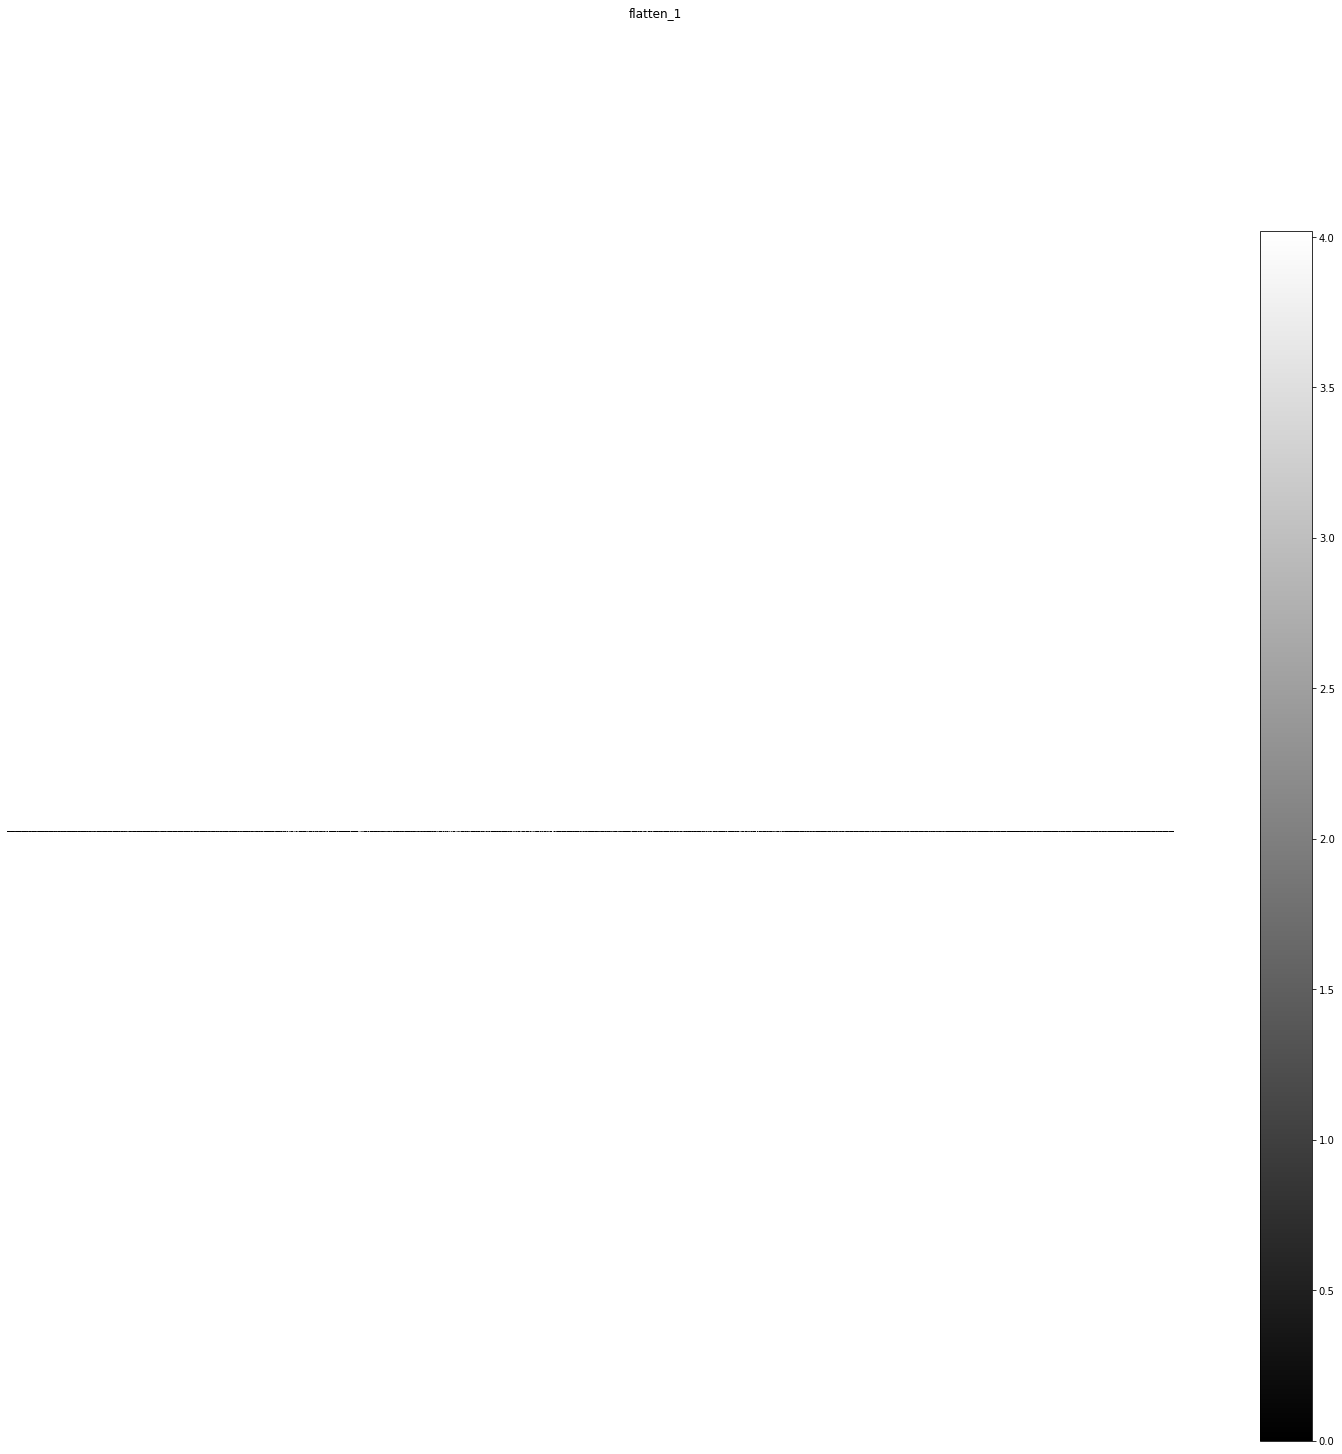

dense_1 (1, 512) 


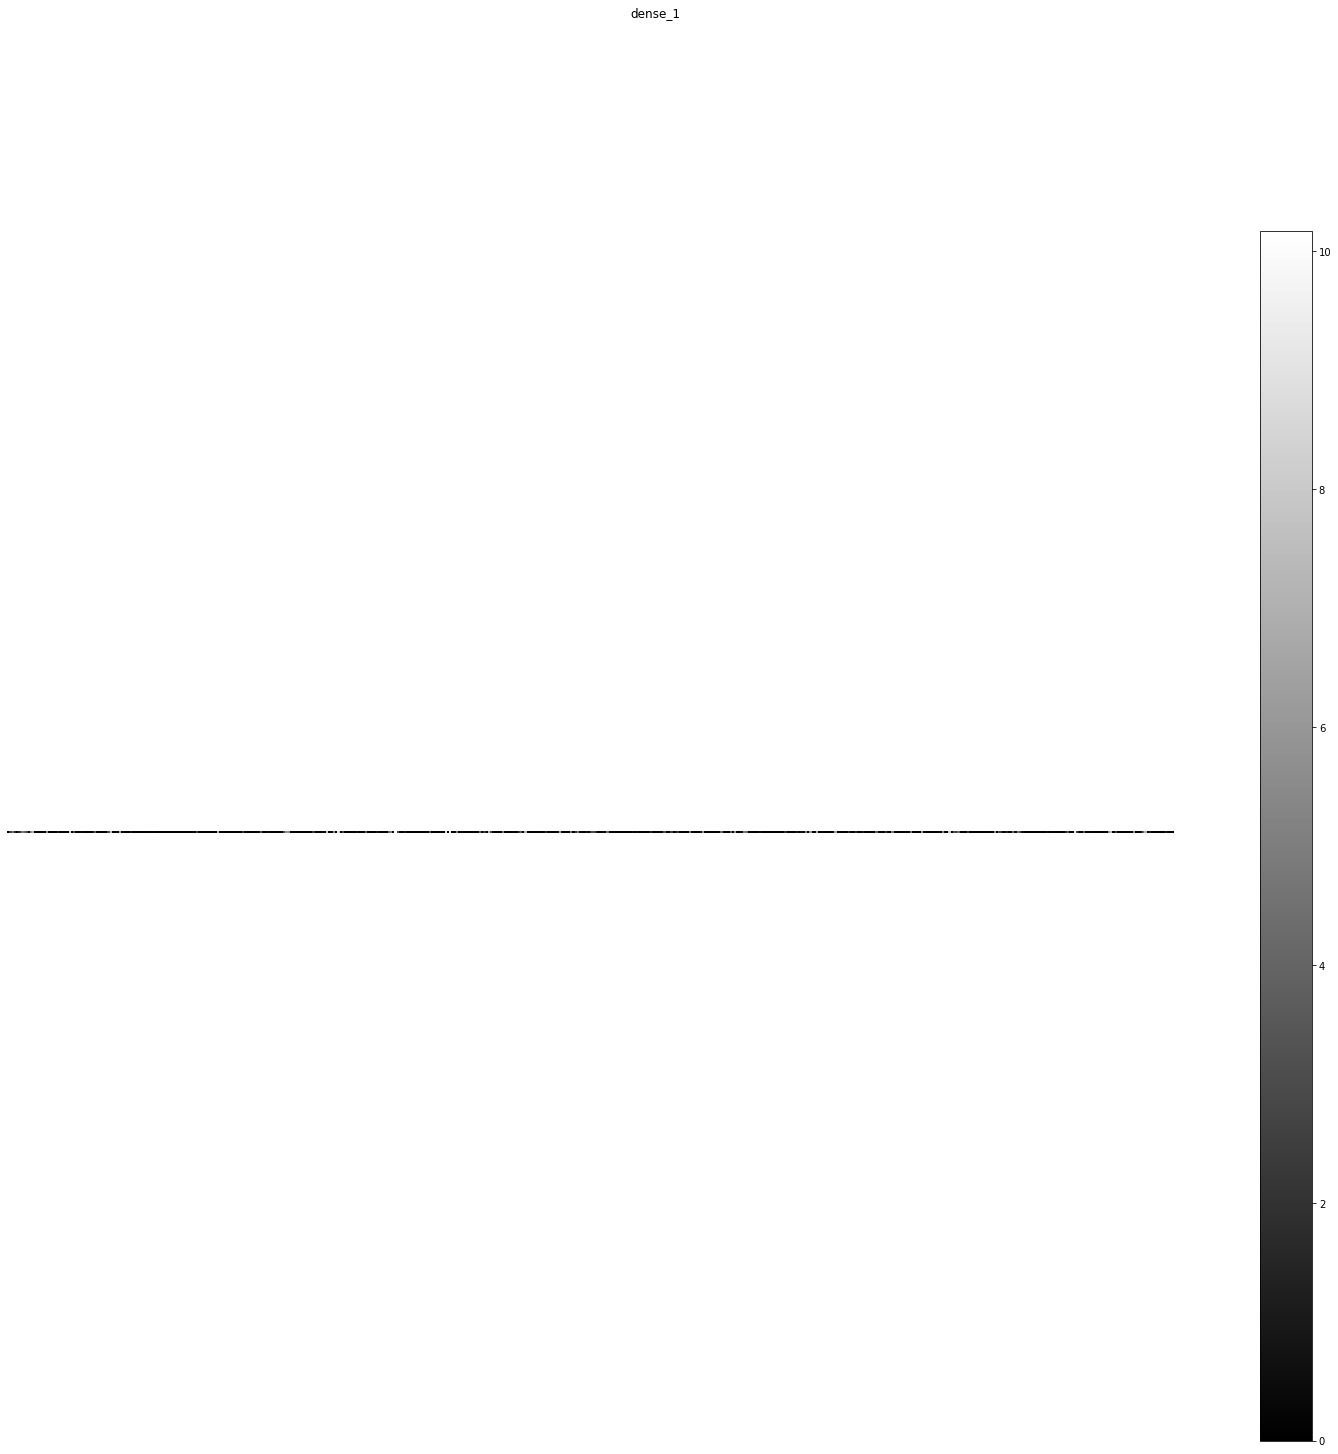

dense_2 (1, 2) 


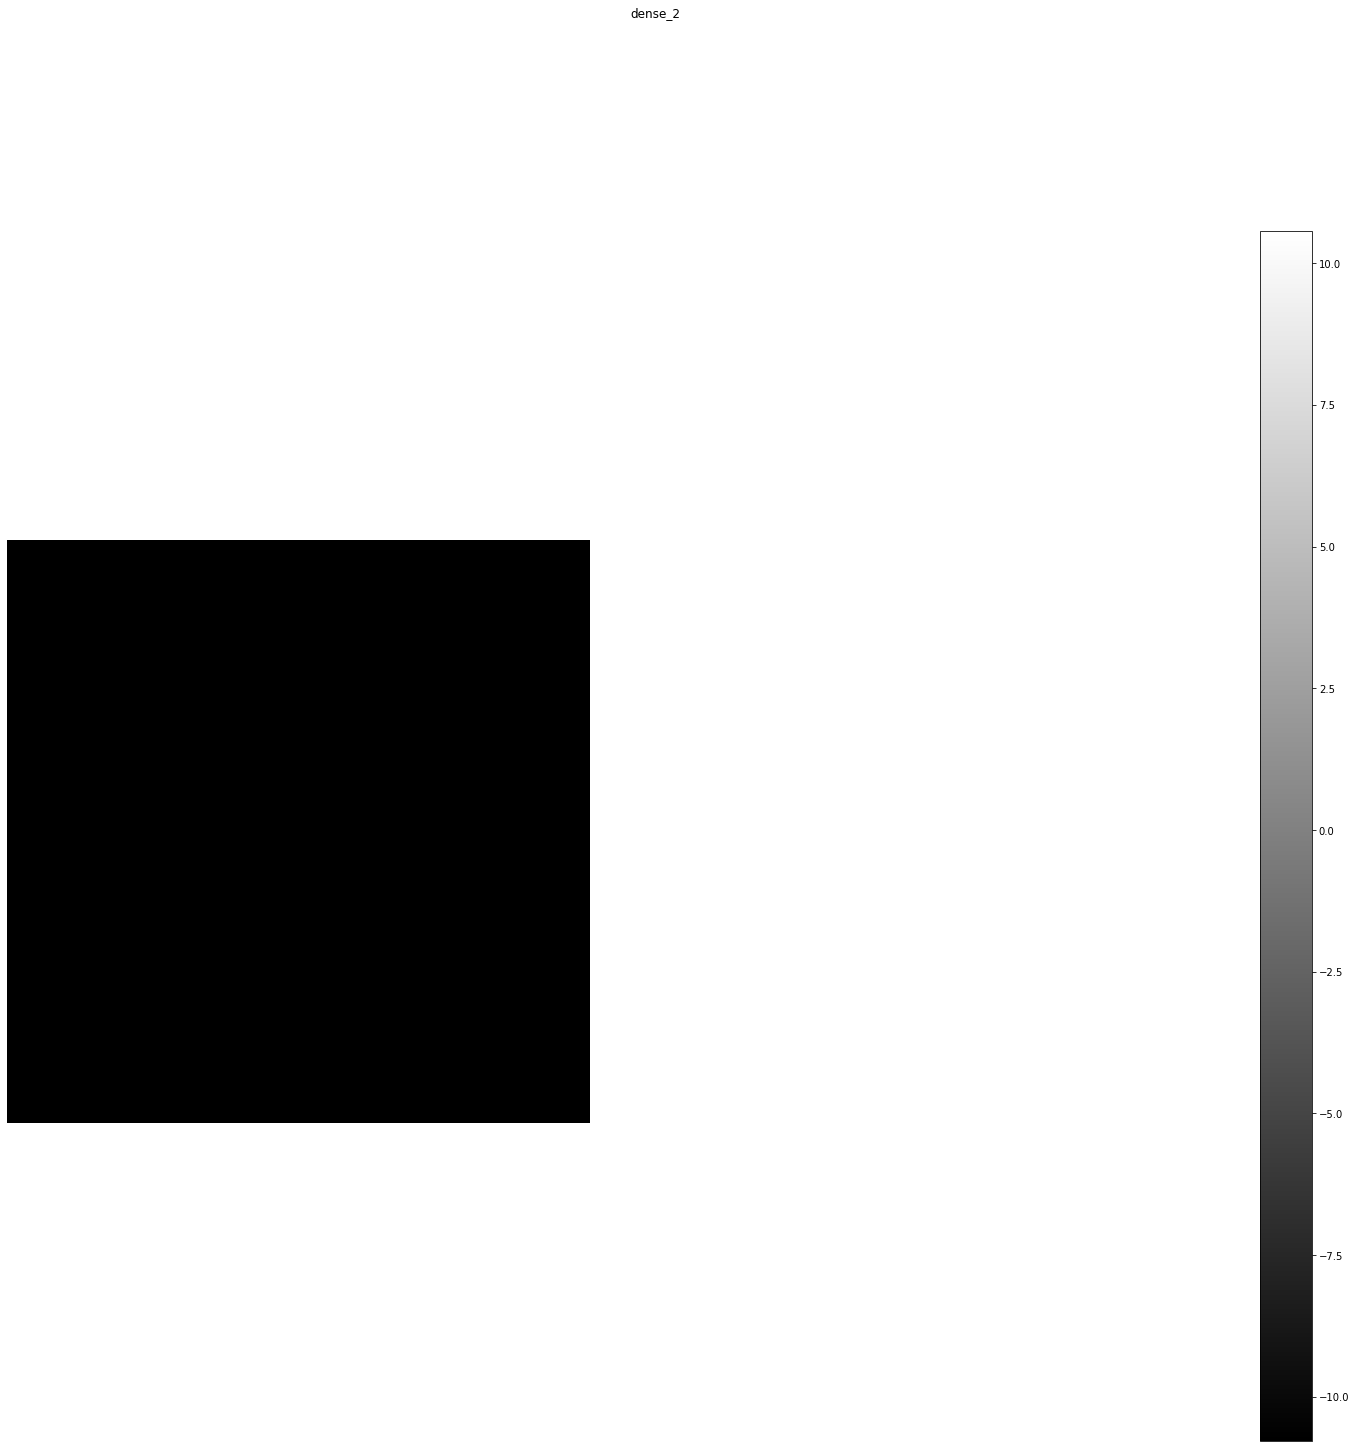

In [24]:
from keract import display_activations
display_activations(activations, cmap="gray", save=False)
#display_activations(activations, save=False)

### Can also display heatmaps

conv2d_1_input (1, 256, 256, 3) 


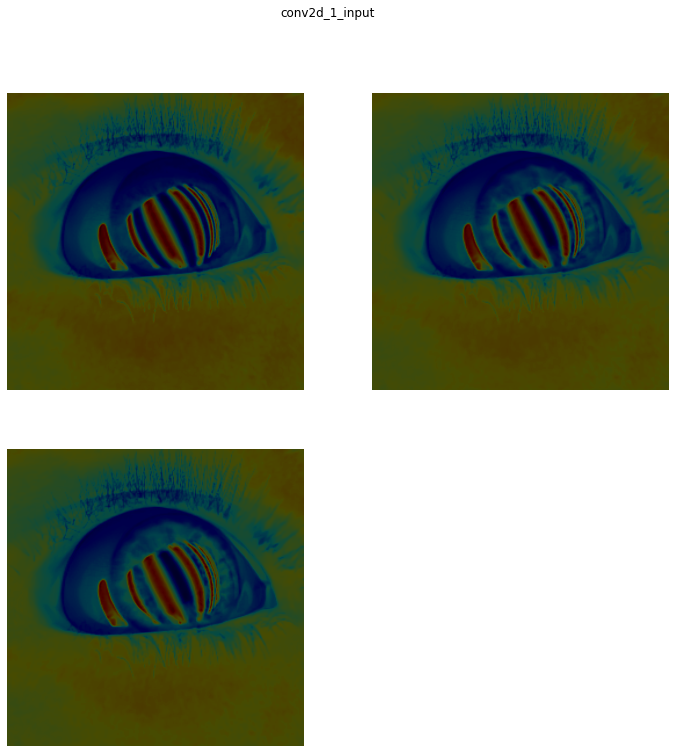

conv2d_1 (1, 254, 254, 16) 


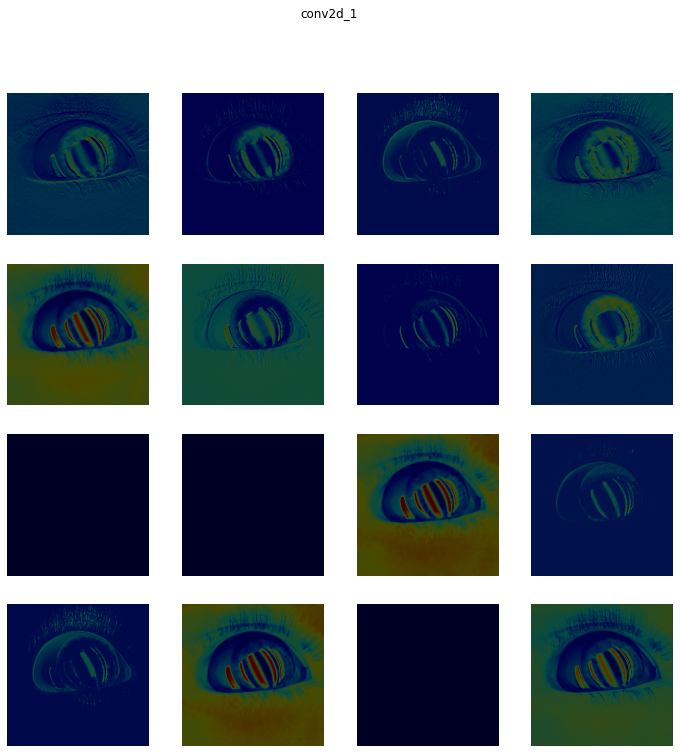

max_pooling2d_1 (1, 127, 127, 16) 


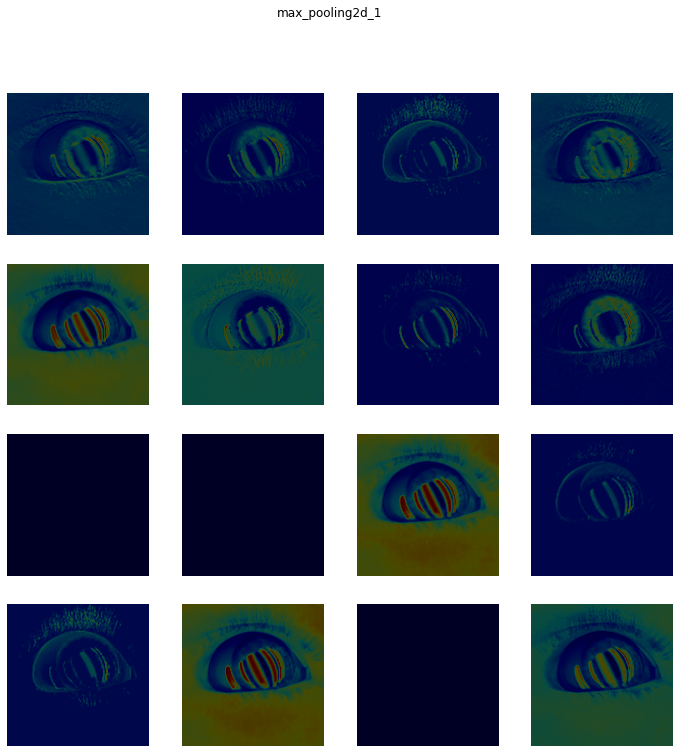

conv2d_2 (1, 125, 125, 32) 


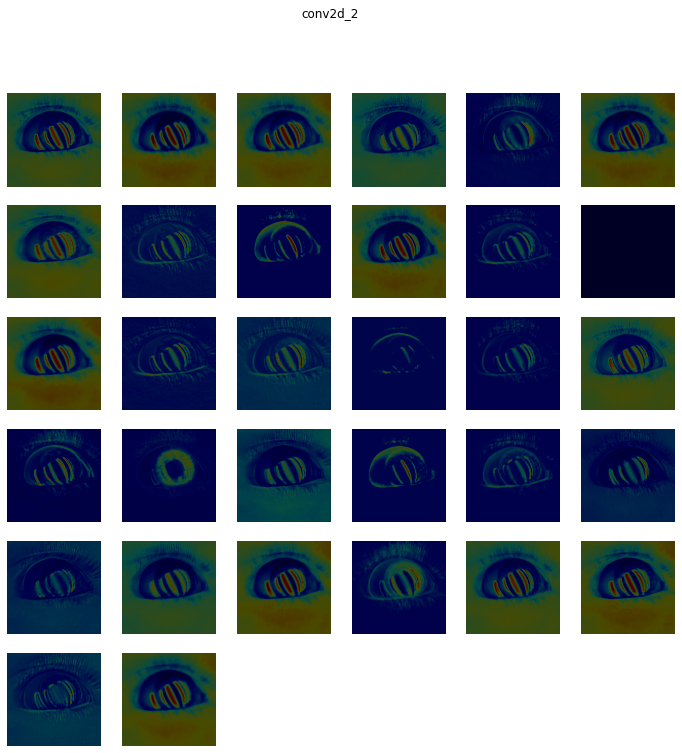

max_pooling2d_2 (1, 62, 62, 32) 


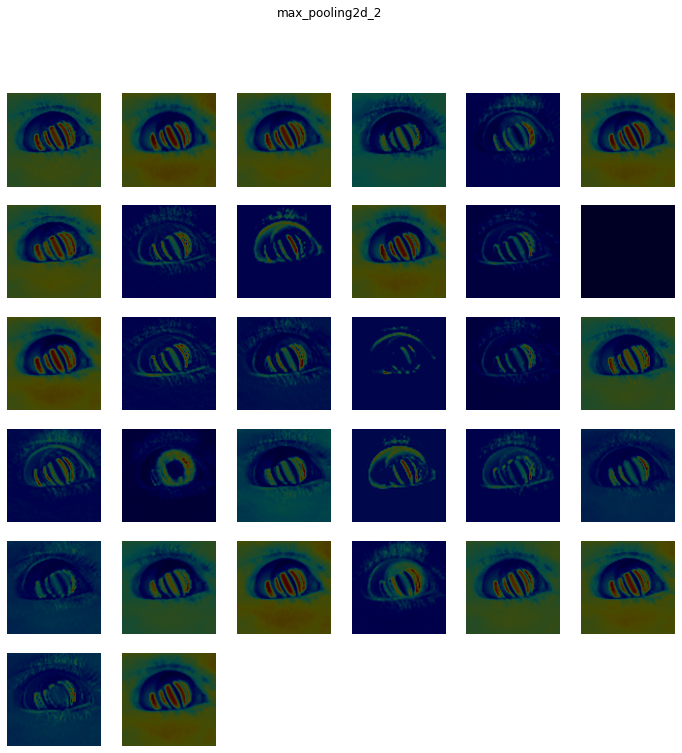

conv2d_3 (1, 60, 60, 64) 


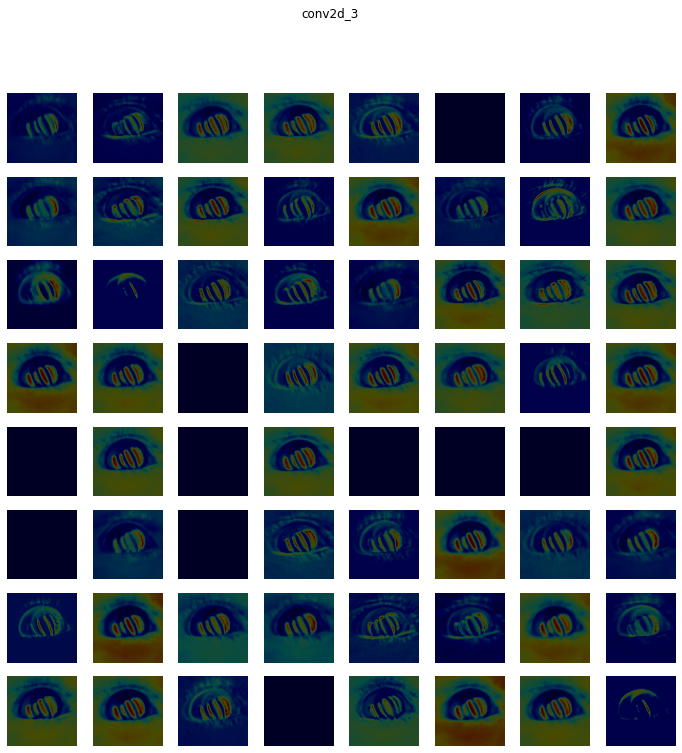

max_pooling2d_3 (1, 30, 30, 64) 


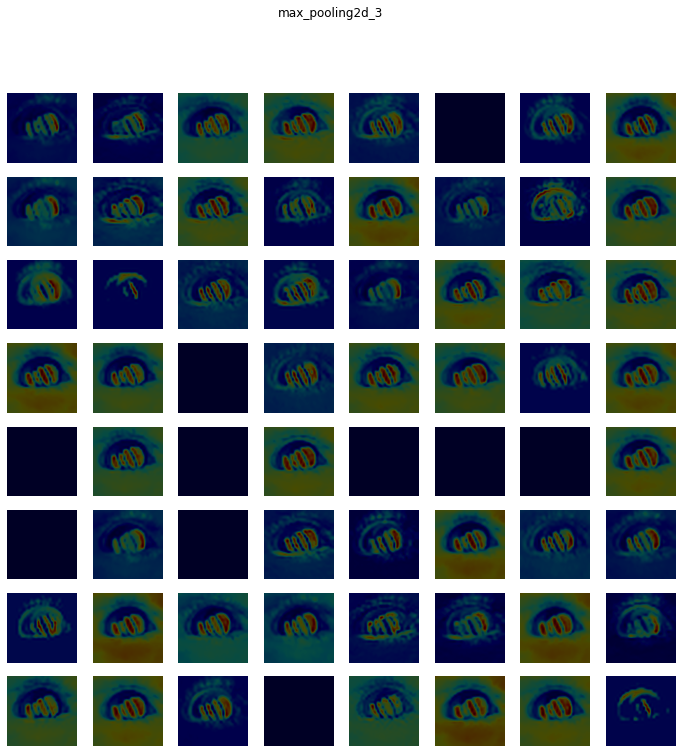

conv2d_4 (1, 28, 28, 64) 


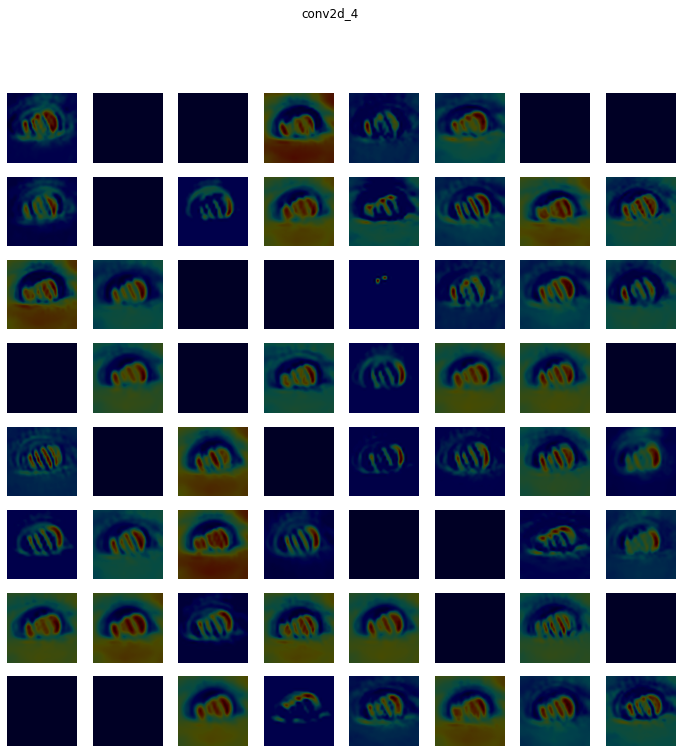

max_pooling2d_4 (1, 14, 14, 64) 


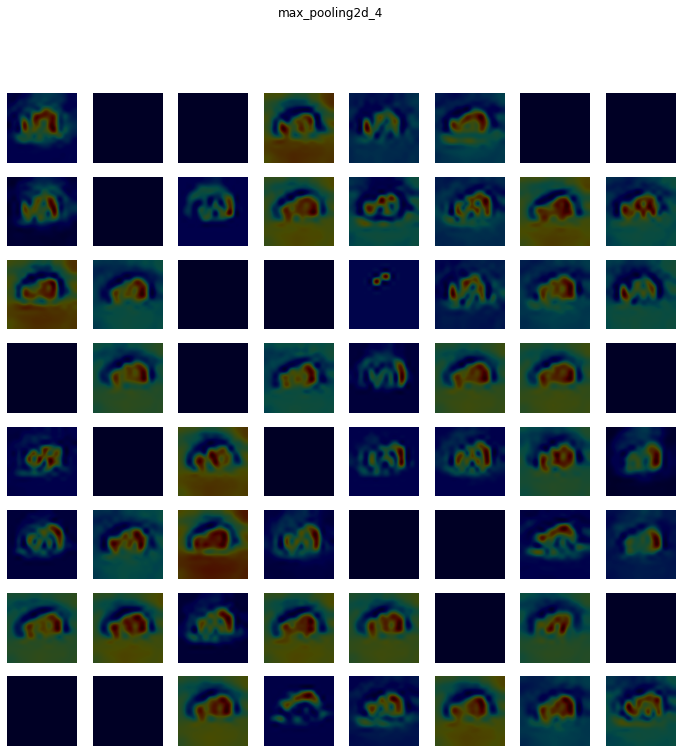

conv2d_5 (1, 12, 12, 64) 


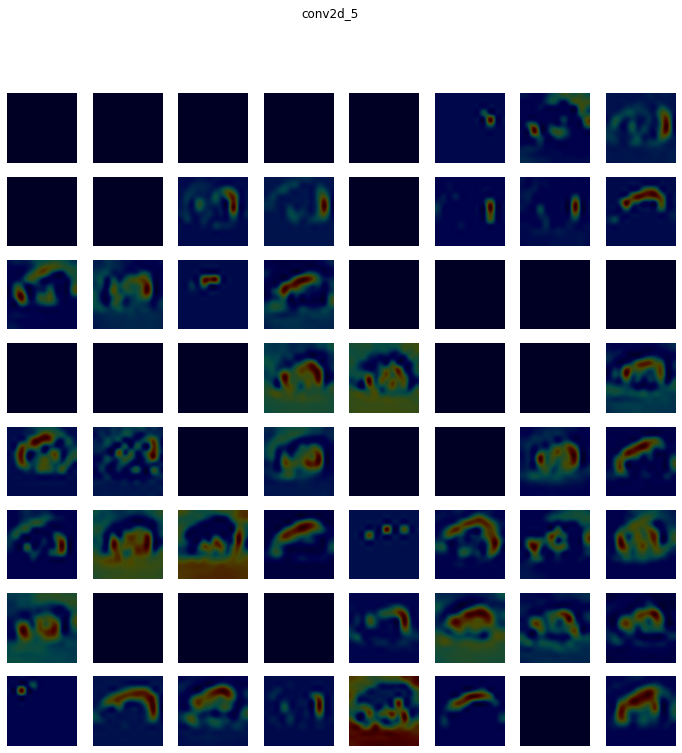

max_pooling2d_5 (1, 6, 6, 64) 


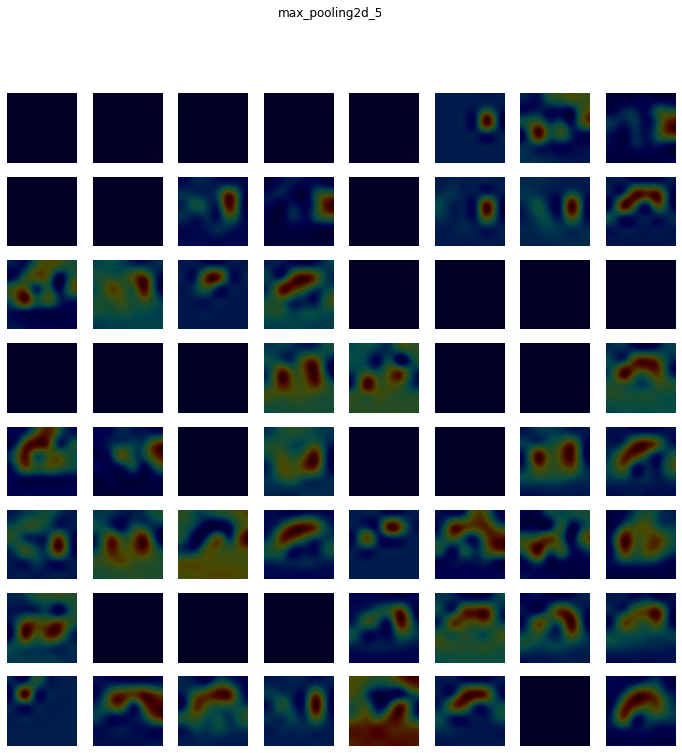

flatten_1 (1, 2304) -> Skipped. 2D Activations.
dense_1 (1, 512) -> Skipped. 2D Activations.
dense_2 (1, 2) -> Skipped. 2D Activations.


In [25]:
from keract import display_heatmaps
display_heatmaps(activations, x, save=False)

In [16]:
### Quiver activation visualizer

In [17]:
from quiver_engine import server
server.launch(model)

ModuleNotFoundError: No module named 'quiver_engine'